
# Construcción de redes de sismos 3D - catalogo completo.



La idea de este notebook es construir/cargar las redes de sismos para diferentes tamaños de celdas. La primera tarea es cargar el catálogo y asignar el identificador de celda a cada sismo, para luego contruir las redes.

Primero, se cargan las librerías para esta tarea.

#### Librerías

In [1]:
import numpy as np
import pandas as pd

import datetime

from obspy.core import UTCDateTime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

import cartopy
import cartopy.crs as ccrs

from scipy.optimize import curve_fit

import math

from dateutil.relativedelta import relativedelta

import pygmt
import networkx as nx

import statistics
import os
import powerlaw

from scipy import stats
from sklearn.neighbors import KernelDensity


Ahora, se definen las funciones que se necesitarán para lo que sigue.

#### Funciones

In [2]:
def gutenberg_richter(x, a, b):
    return a - b * x

def calculacelda(ltmin,lnmin,tmcel,gr2km,ancho,largo,lat,lon):
    idx=ancho/tmcel
    i=int((lat-ltmin)*gr2km/tmcel)
    j=i*idx
    
    k=int((lon-lnmin)*gr2km/tmcel)
    return int(k+j+1)

def calculaceldaprof(ltmin,lnmin,tmcel,gr2km,ancho,largo,lat,lon,prof):
    idx=ancho/tmcel
    i=int((lat-ltmin)*gr2km/tmcel)
    j=i*idx
    k=int((lon-lnmin)*gr2km/tmcel)
    #ki=int(i+j+1)
    ki=int(k+j+1)
    
    idp=int(prof/tmcel)
    idy=largo/tmcel
    idxy=idy*idx + 2
    #fidp=int(idp*idp)
    fidp=int(idxy*idxy)*idp

    return ki + fidp

def gradprom( g ):
    return sum(dict(g.degree()).values())/len(g.degree())

def disprobgrado(grafo):
    m=nx.adjacency_matrix(grafo)
    v=[0 for i in range (m.shape[0])]
    v1=[0 for i in range (m.shape[0])]
    for i in range (m.shape[1]):
        i1=m[i].todense().sum()
        v[i1-1]=v[i1-1]+1
    tod=sum(v)
    for i in range(m.shape[1]):
        v1[i]=v[i]/tod
    return v1

def disestas(p1,p2):
    e1=dentropy([(p1[i]+p2[i])/2 for i in range(len(p1))])
    e2=(dentropy(p1)+dentropy(p2))/2
    return e1-e2

def dentropy(v):
    v1=[i*math.log(i) for i in list(filter(lambda x: x>0, v))]
    s1=-sum(v1)/math.log(len(v)-1)
    return s1

def smallworldness(g):
    n=nx.number_of_nodes(g)
    gp=gradprom(g)
    c=nx.average_clustering(g)
    p=nx.average_shortest_path_length(g)
    sw=c*n*np.log(n)/(p*gp*np.log(gp))
    return sw

def myExpFunc(x, a, b):
    return a * np.power(x, b)

def fpdfclusterbetween(grafo, bw):
    dcl=np.array(list(nx.clustering(grafo).values()))
    dbt=np.array(list(nx.betweenness_centrality(grafo).values()))
    modelc=KernelDensity(kernel='gaussian', bandwidth=bw)
    modelb=KernelDensity(kernel='gaussian', bandwidth=bw)
    modelc.fit(dcl[:,None])
    modelb.fit(dbt[:,None])
    
    xcl=np.linspace(dcl.min()-bw/2,dcl.max()+bw/2,100)
    vcl = xcl.reshape((len(xcl), 1))
    probcl = modelc.score_samples(vcl)
    eprobcl = np.exp(probcl)
    s=eprobcl.sum()
    neprobcl=eprobcl/s
    #eclusters.append(dentropy(neprobcl))
    #pdfcluster.append(neprobcl)

    xbt=np.linspace(dbt.min()-bw/2,dbt.max()+bw/2,100)
    vbt = xbt.reshape((len(xcl), 1))
    probbt = modelb.score_samples(vbt)
    eprobbt = np.exp(probbt)
    s=eprobbt.sum()
    neprobbt=eprobbt/s
    #ebetweens.append(dentropy(neprobbt))
    #pdfbetween.append(neprobbt)

    return neprobcl, neprobbt

def fpdfcluster(grafo, bw):
    dcl=np.array(list(nx.clustering(grafo).values()))
    #dbt=np.array(list(nx.betweenness_centrality(grafo).values()))
    modelc=KernelDensity(kernel='gaussian', bandwidth=bw)
    #modelb=KernelDensity(kernel='gaussian', bandwidth=bw)
    modelc.fit(dcl[:,None])
    #modelb.fit(dbt[:,None])
    
    xcl=np.linspace(dcl.min()-bw/2,dcl.max()+bw/2,100)
    vcl = xcl.reshape((len(xcl), 1))
    probcl = modelc.score_samples(vcl)
    eprobcl = np.exp(probcl)
    s=eprobcl.sum()
    neprobcl=eprobcl/s
    #eclusters.append(dentropy(neprobcl))
    #pdfcluster.append(neprobcl)

    #xbt=np.linspace(dbt.min()-bw/2,dbt.max()+bw/2,100)
    #vbt = xbt.reshape((len(xcl), 1))
    #probbt = modelb.score_samples(vbt)
    #eprobbt = np.exp(probbt)
    #s=eprobbt.sum()
    #neprobbt=eprobbt/s
    #ebetweens.append(dentropy(neprobbt))
    #pdfbetween.append(neprobbt)

    return neprobcl

#### Se carga el catálogo completo de sismicidad.

In [3]:
ltmin=-5
lnmin=-82
ltmax=13
lnmax=-66

gr2km=111

largo=((((ltmax-ltmin)*gr2km)//100)+(1 if ((ltmax-ltmin)*gr2km)%100 > 1 else 0))*100
ancho=((((lnmax-lnmin)*gr2km)//100)+(1 if ((lnmax-lnmin)*gr2km)%100 > 1 else 0))*100

fullcatalogo=pd.read_csv("./catalogo-usgs-20231011.csv", parse_dates=["time"])


In [ ]:
#fullcatalogo[fullcatalogo["time"]>'1972-12-31']

#### Análisis de sismicidad para encontrar Mc y Gutenberg-Richter

En esta celda, se corre el análisis de Gutenberg-Richter al catálogo completo, y se arma el catálogo con el que se va a trabajar. Se genera un nuevo catálogo llamado `catalogo`, un vector `tamcel` con los tamaños de celda, un arreglo de grafos `grafos` con todos los grafos construidos. Esta celda demora 30s.

In [4]:
%%time

#Tiempo de inicio. Los eventos anteriores se descartan.
tini=UTCDateTime("1973-01-01T00:00:00Z")
#Magnitud mínima para calcular la distribución GR
mc=3.9
#Magnitud máxima para calcular la distribución GR
mmax=7.5
#La magnitud de completitud es la magnitud mínima mas este delta.
dmc=0.2

#Se crea el catálogo
catalogo=fullcatalogo[["time","latitude","longitude","depth","mag"]]

#se crea una nueva columna en los datos con el epoch de la fecha. Esto para poder comparar.
catalogo["epochs"]=(catalogo["time"]-pd.Timestamp("1970-01-01T00:00:00Z"))//pd.Timedelta('1s')

#se filtra el catálogo por fechas
catalogo=catalogo[(catalogo["epochs"]>tini)&((catalogo["latitude"]<ltmax)&(catalogo["latitude"]>ltmin))&((catalogo["longitude"]>lnmin)&(catalogo["longitude"]<lnmax))]

#Se crea la distribución de magnitudes vs. N de eventos.
magnitudes=catalogo.mag.values
magnitudes=magnitudes[magnitudes>=mc]
magnitudes=magnitudes[magnitudes<mmax]
magnitudes.sort()
magnitudes

num_events = np.arange(1, len(magnitudes)+1)
cumulative_dist = num_events[::-1] #/num_events[-1]

#Se ajusta una curva a la distribución de magnitudes.
popt, pcov = curve_fit(gutenberg_richter, magnitudes, np.log10(cumulative_dist))

parama=popt[0]
y=gutenberg_richter(magnitudes,parama,popt[1])
listamags=np.arange(1.05,8.5,0.1)

listacants=[]
for lmag in listamags:
    l=(catalogo.mag > lmag)
    listacants.append(sum(l))
    
#Se crea un dataframe con las magnitudes y cantidad de eventos.
gutrich=pd.DataFrame(listamags,columns=["Mag"])
gutrich.insert(len(gutrich.columns),"N",listacants)
nlogs=np.log10(gutrich.N)
gutrich.insert(len(gutrich.columns),"logN",nlogs)
gutrich["logN"]=gutrich['logN'].replace(-np.inf,0)

mmin=mc+dmc-0.001

#Tamaño de celdas, para construir las redes de sismos
tamcel=[r for r in range(10,122,2)]

#se crea una nueva columna en los datos con el epoch de la fecha. Esto para poder comparar.
catalogo["epochs"]=(catalogo["time"]-pd.Timestamp("1970-01-01T00:00:00Z"))//pd.Timedelta('1s')

#un catálogo con los datos posteriores a la fecha inicial
catalogo=catalogo[((catalogo["epochs"]>tini) & (catalogo["mag"] > mmin))&((catalogo["latitude"]<ltmax)&(catalogo["latitude"]>ltmin))&((catalogo["longitude"]>lnmin)&(catalogo["longitude"]<lnmax))]

#se calcula la energía sismica de los eventos, y se inserta en la tabla como columna "energia". La formula usada
#es tomada de Stein, pagina 273. OJO! en stein, la formula es en ergios, por eso se debe restar un 7 para que quede
#en julios.
e=[]
for i, lin in catalogo.iterrows():
    e.append(math.pow(10,4.8+1.5*lin["mag"]))

catalogo.insert(len(catalogo.columns),"energia",e)

print("se tiene catalogo completo")


#CALCULO DE GRAFOS
grafos=[]
disprobs=[]
gammas=[]

limsup=80
liminf=6

for tcel in tamcel:
    cp=[]
    for i, lin in catalogo.iterrows():
        cp.append(calculaceldaprof(ltmin,lnmin,tcel,gr2km,ancho,largo,lin["latitude"],lin["longitude"],lin["depth"]))

    grafoprof=nx.Graph()
    tam=len(cp)
    for j in range(1,tam):
        grafoprof.add_edge(cp[j-1],cp[j])

    catalogo.insert(len(catalogo.columns),"celda"+str(tcel),cp)
    grafos.append(grafoprof)
    d=disprobgrado(grafoprof)
    x=[i+liminf+1 for i in range(limsup)]
    y=[d[i+liminf] for i in range(limsup)]
    popt, pcov = curve_fit(myExpFunc, x, y)
    gammas.append([tcel,popt[1],limsup,liminf])

    disprobs.append(d)

dfgammas=pd.DataFrame(gammas,columns=["tcel","gamma","limsup","liminf"])

print("se tiene catalogo completo con identificacion de celdas")


# Se crean los grafos - redes de sismos.
#grafos=[]

#for tcel in tamcel:
    #print(tcel)
#    cc2=catalogo["celda"+str(tcel)]
#    grafoprof=nx.Graph()

#    tam=len(catalogo["celda"+str(tcel)])
#    for j in range (1,tam):
#        grafoprof.add_edge(cc2.iloc[j-1],cc2.iloc[j])

#    grafos.append(grafoprof)
    

#Distribuciones de grados
#disprobs=[]
#for g in grafos:
#    disprobs.append(disprobgrado(g))

#Se calculan los gammas de las redes de sismos
#gammas=[]
#limsup=80
#liminf=6

#for tcel in range(10,121,2):

#    indice=tamcel.index(tcel)
    
#    x=[i+liminf+1 for i in range(limsup)]
#    y=[disprobs[indice][i+liminf] for i in range(limsup)]
#    popt, pcov = curve_fit(myExpFunc, x, y)
#    gammas.append([tcel,popt[1],limsup,liminf])
#dfgammas=pd.DataFrame(gammas,columns=["tcel","gamma","limsup","liminf"])


<timed exec>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/danileo/miniconda3/envs/redessismos/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


se tiene catalogo completo
se tiene catalogo completo con identificacion de celdas
CPU times: user 26.7 s, sys: 218 ms, total: 26.9 s
Wall time: 27.6 s


# GRAFICAS

Gutenberg-Richter

Text(0.5, 1.0, 'Gutenberg-Richter distribution - Mc:4.1 - Log(N)=7.74340411656 - 0.954162904368*Mag')

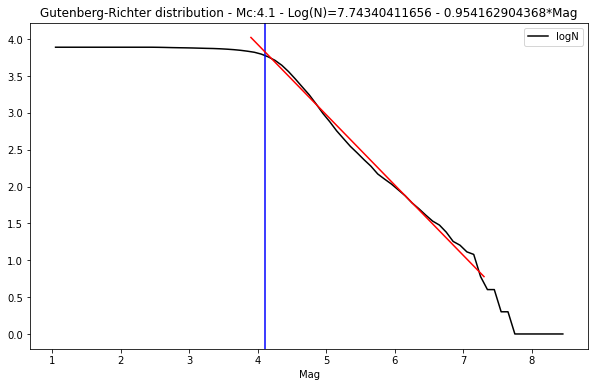

In [9]:
fig, ax1 = plt.subplots(figsize=(10,6))
gutrich.plot(x='Mag',y='logN',kind='line',ax=ax1,color='black')
plt.axvline(x=mc+dmc,color='b')
popt, pcov = curve_fit(gutenberg_richter, magnitudes, np.log10(cumulative_dist))
parama=popt[0]
y=gutenberg_richter(magnitudes,parama,popt[1])
plt.plot(magnitudes, y, 'r-', label='fit')
plt.title("Gutenberg-Richter distribution - Mc:"+str(mc+dmc)+" - Log(N)="+str(parama)+" - "+str(popt[1])+"*Mag")


Mapa de la sismicidad.

CPU times: user 235 ms, sys: 20.6 ms, total: 256 ms
Wall time: 3.65 s


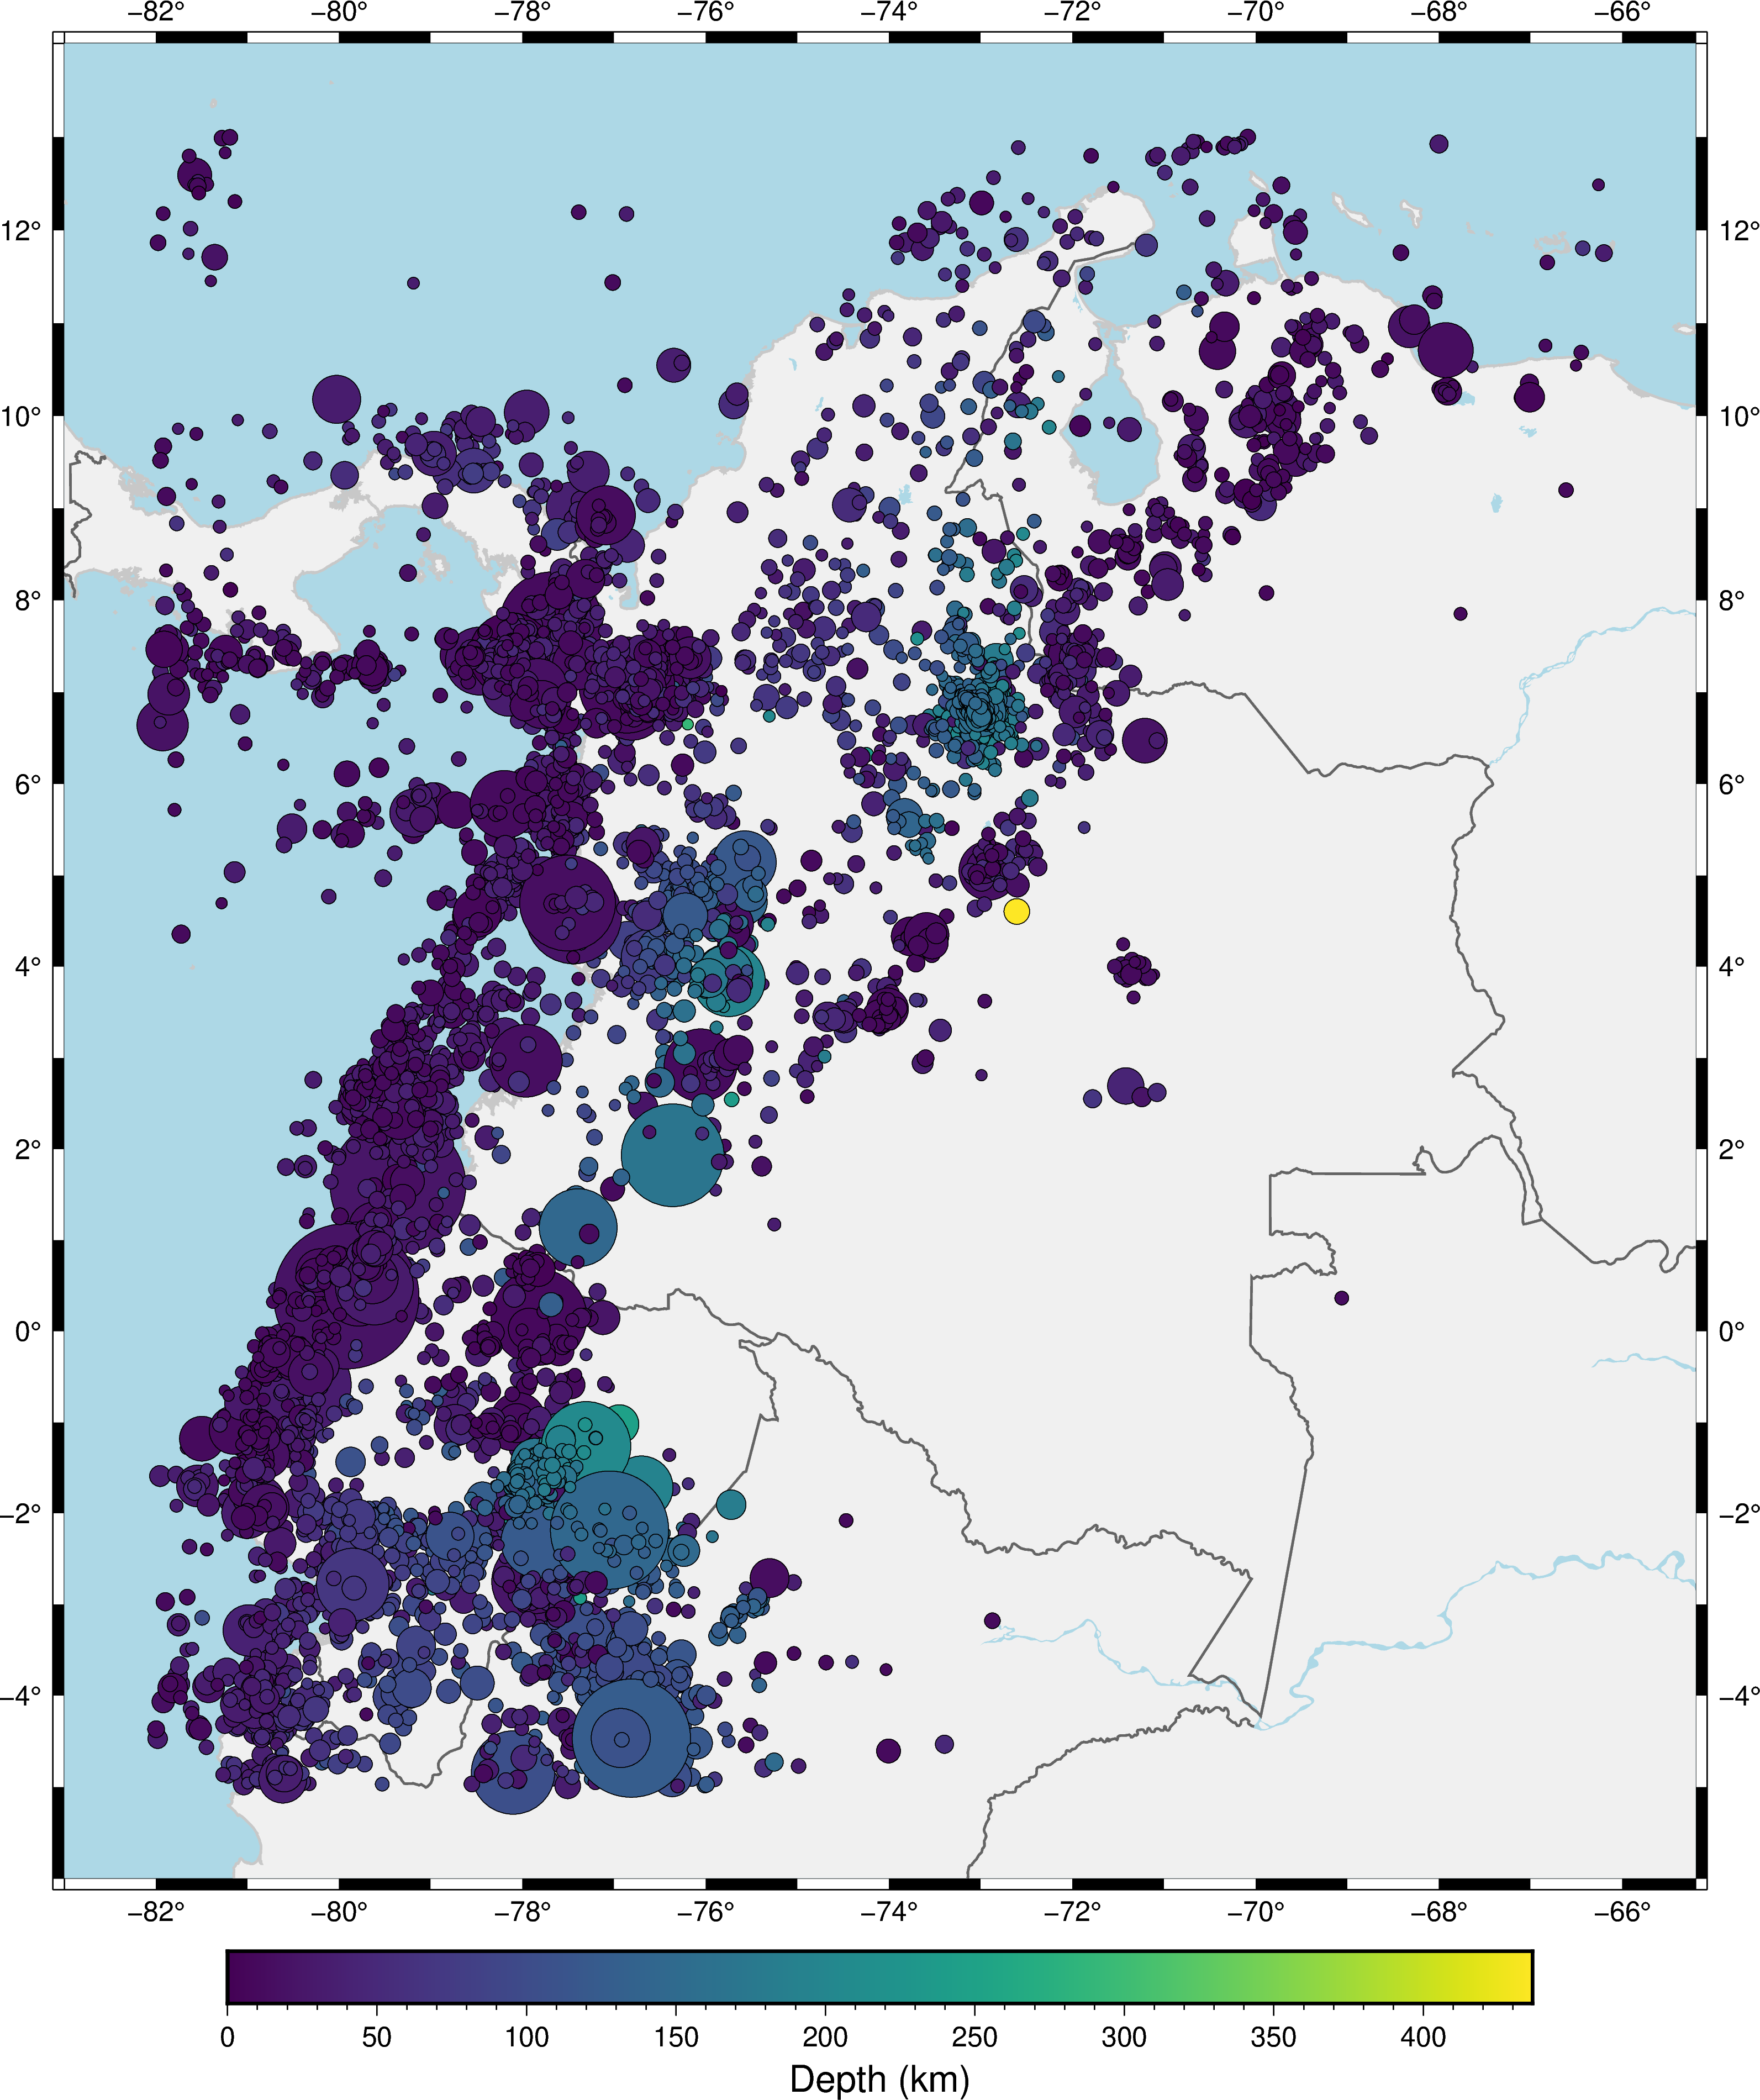

In [10]:
%%time
#region=[-84,-65,-6,13]
#print(region)

region=[min(catalogo["longitude"])-1, max(catalogo["longitude"])+1, min(catalogo["latitude"])-1, max(catalogo["latitude"])+1]

fig=pygmt.Figure()
fig.basemap(region=region, projection="M25c", frame=True)

pygmt.makecpt(cmap="viridis", series=[catalogo.depth.min(), catalogo.depth.max()])
fig.coast(shorelines="1/1p,200",borders="1/1p,100",water="lightblue",land="240/240/240")
fig.plot(x=catalogo["longitude"],y=catalogo["latitude"],sizes=0.01*(2 ** catalogo["mag"]) ,color=catalogo["depth"],cmap=True,style="cc",pen="black")
fig.colorbar(frame='af+l"Depth (km)"')
fig.show()

In [ ]:
#Se hace un histograma de profundidad de eventos.

c=catalogo.depth
dfcol=pd.DataFrame(c)
dfcol.plot(kind='hist',title="Histograma de profundidad de eventos")


In [ ]:
# TEST PARA GRAFICAR LA DISTRIBUCIÓN DE PROBABILIDAD DE GRADO VS. GRADO EN LOG-LOG
# ESTO PERMITE VER EL GAMMA.

tcel=100
limsup=80
liminf=6
indice=tamcel.index(tcel)
print(tamcel[indice])
#se hace hasta grado=100
x=[i+liminf+1 for i in range(limsup)]
y=[disprobs[indice][i+liminf] for i in range(limsup)]
fx=[i+1 for i in range (len(disprobs[indice]))]
#plt.loglog(x,disprobs[indice])

#p=np.polyfit(np.log(x),np.log(disprobs[indice]),1)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(fx, disprobs[indice], s=60, alpha=0.7, edgecolors="k")

newX = np.logspace(0.5, 2, base=10)  # Makes a nice domain for the fitted curves.
                                   # Goes from 10^0 to 10^3
                                   # This avoids the sorting and the swarm of lines.

popt, pcov = curve_fit(myExpFunc, x, y)
plt.plot(newX, myExpFunc(newX, *popt), 'r-', 
         label="({0:.3f}*x**{1:.3f})".format(*popt))
#print "Exponential Fit: y = (a*(x**b))"
#print "\ta = popt[0] = {0}\n\tb = popt[1] = {1}".format(*popt)
plt.legend(loc='upper right')


# Set logarithmic scale on the both variables
ax.set_xscale("log")
ax.set_xlabel("log(k)")
ax.set_yscale("log")
ax.set_ylabel("log(P(k))")

ax.set_title("k vs. p(k) - dx="+str(tcel)+" km")

print(tcel,popt[1])

In [ ]:
#Se grafican los gammas vs. tcelda.

fig, ax1 = plt.subplots(figsize=(10,6))

dfgammas.plot(x='tcel',y='gamma',kind='line',ax=ax1,color='black')
ax1.set_xlabel("Tamaño de celda")

# Generacion de datos - corridas largas

La siguiente celda se corre SOLAMENTE si se tienen que generar el catálogo de parametros de las redes de sismos, que queda en dataframe `dfdatosprof`

In [ ]:
%%time

######################## SE DEMORA 20 minutos ############################

losdatos=[]

for itcel in range(len(tamcel)):
    tcel=tamcel[itcel]
    grafoprof=grafos[itcel]

    print(tcel)
    #cc2=catalogo["celda"+str(tcel)]

    tam=len(catalogo["celda"+str(tcel)])
    
    #clusterings
    clustprof=nx.average_clustering(grafoprof)
            
    #average path length
    pathsprof=nx.average_shortest_path_length(grafoprof)
            
    #numero de bordes
    nedgesprof=grafoprof.number_of_edges()
            
    #numero de nodos
    nodosprof=nx.number_of_nodes(grafoprof)
            
    #Grado promedio
    gradsprof=gradprom( grafoprof )
            
    #distribucion de grado
    prgradprof=disprobgrado(grafoprof)
            
    #Entropia
    entprof=dentropy(prgradprof)
            
    #Smallworldness
    smallworldprof=smallworldness(grafoprof)
            
    #betweenness centrality
    betweenprof=list(nx.betweenness_centrality(grafoprof).values())

    #energia
    energia=sum(catalogo["energia"])
    losdatos.append([tcel,nodosprof,nedgesprof,gradsprof,clustprof,pathsprof,entprof,smallworldprof,betweenprof,prgradprof,energia])

dfdatosprof=pd.DataFrame(losdatos,columns=["tcel","nodos","edges","grado","cluster","path","entropia","smallworld","betweeness","disgrado","energia"])

dfdatosprof["gamma"]=dfgammas["gamma"]

nbetween=[]
for d in dfdatosprof["betweeness"]:
    #d1=d.strip("[]")
    #d2=d1.split(",")
    #d3=[float(d4) for d4 in d2]
    d3=[float(d4) for d4 in d]

    nbetween.append(np.mean(d3))
dfdatosprof["meanbetween"]=nbetween
dfdatosprof=dfdatosprof.drop(["betweeness"],axis=1);

dfdatosprof.to_csv("datos-redes-profundidad-catalogocompleto-new.csv")


Se genera dataframe con datos de celda, `dftcelsall`, que tiene datos para cada celda y para cada tamaño.

In [ ]:
%%time

dftcels=[pd.pivot_table(catalogo,values="energia",index=["celda"+str(t)],aggfunc={'energia':[np.mean,np.sum,np.median,stats.mode,'count']}) for t in tamcel]

nevs=len(catalogo)
#salida=[]
for i in range(len(grafos)):
    t=tamcel[i]
    print("inicia grafo",t)
    g=grafos[i]
    ns=list(g.nodes)
    bc=nx.betweenness_centrality(g)
    l=len(dftcels[i])
    dftcels[i]["latitude"]=np.zeros(l)
    dftcels[i]["longitude"]=np.zeros(l)
    dftcels[i]["depth"]=np.zeros(l)
    dftcels[i]["degree"]=np.zeros(l)
    dftcels[i]["clustering"]=np.zeros(l)
    dftcels[i]["betweeness"]=np.zeros(l)
    dftcels[i]["eccentricity"]=np.zeros(l)
    dftcels[i]["nevents"]=np.zeros(l)
    
    for n in ns:
        lt=catalogo[catalogo["celda"+str(t)]==n].latitude.mean()
        ln=catalogo[catalogo["celda"+str(t)]==n].longitude.mean()
        dp=catalogo[catalogo["celda"+str(t)]==n].depth.mean()
        gr=nx.degree(g,n)
        cl=nx.clustering(g,n)
        b=bc[n]
        nevs=len(catalogo[catalogo["celda"+str(t)]==n])
        ec=nx.eccentricity(g,n)
        dftcels[i].loc[n, ["latitude","longitude","depth","degree","clustering","betweeness","eccentricity","nevents"]]=lt,ln,dp,gr,cl,b,ec,nevs
        #salida.append([i,t,lt,ln,dp,gr,cl,b,nevs,ec])
    print("termina grafo",t)

datcelsall=[]
for i in range(len(tamcel)):
    tam=tamcel[i]
    for ind, row in dftcels[i].iterrows():
        v=[]
        v.append(tam)
        v.append(ind)
        for colum in dftcels[i].columns:
            v.append(row[colum])
        datcelsall.append(v)

dftcelsall=pd.DataFrame(datcelsall,columns=["tcel","celda","count","mean","median","mode","sum","latitude","longitude","depth","degree","clustering","betweeness","eccentricity","nevents"])
dftcelsall.to_csv("datosceldasredessismos.csv")

In [ ]:
%%time
series=[]
for t in tamcel:
    print(t)
    s=[]
    #    print(t)
    #t=10
    for v in list(catalogo["celda"+str(t)].values):
        #v=1803
        s.append(list(dftcelsall[(dftcelsall["tcel"]==t) & (dftcelsall["celda"]==v)][["celda","count","mean","median","sum","latitude","longitude","depth","degree","clustering","betweeness","eccentricity"]].values[0]))
    dfs=pd.DataFrame(s,columns=["celda","count","mean","median","sum","latitude","longitude","depth","degree","clustering","betweeness","eccentricity"])
    series.append(dfs)

for t in range(len(tamcel)):
    series[t].to_csv("serie-"+str(tamcel[t])+".csv")
    print(tamcel[t])


# Carga de datos anteriormente generados

Si no se van a generar, sino que ya se han generado antes y se van a cargar, se corre esta celda.

In [5]:
dfdatosprof=pd.read_csv("datos-redes-profundidad-catalogocompleto-new.csv")
dftcelsall=pd.read_csv("datosceldasredessismos.csv")

In [6]:
%%time
series1=[]
for t in tamcel:
    f=pd.read_csv("serie-"+str(t)+".csv")
    series1.append(f.drop(["Unnamed: 0"],axis=1))

CPU times: user 888 ms, sys: 179 ms, total: 1.07 s
Wall time: 2.23 s


In [94]:
series1[0].columns

Index(['celda', 'count', 'mean', 'median', 'sum', 'latitude', 'longitude',
       'depth', 'degree', 'clustering', 'betweeness', 'eccentricity'],
      dtype='object')

In [109]:
tcel

120

In [ ]:
%%time
xvectores=[]
yclases=[]
tamvectores=50
tcel=50
series1[tamcel.index(tcel)]
for i in range(len(series1[tamcel.index(tcel)])-tamvectores):
    x=[]
    for j in range(tamvectores):
        x.append(series1[tamcel.index(tcel)].loc[i+j])
    xvectores.append(x)
    yclases=int(series1[tamcel.index(tcel)].loc[i+tamvectores].celda)

In [118]:
int(series1[20].loc[50].celda)
#len(series1[20])-50
#for i in range(0):
#    print(i)

765

In [108]:
for i in range(50):
    print(6211+i)

6211
6212
6213
6214
6215
6216
6217
6218
6219
6220
6221
6222
6223
6224
6225
6226
6227
6228
6229
6230
6231
6232
6233
6234
6235
6236
6237
6238
6239
6240
6241
6242
6243
6244
6245
6246
6247
6248
6249
6250
6251
6252
6253
6254
6255
6256
6257
6258
6259
6260


Con datos cargados, se siguen calculando cosas.

Se ha calculado, para cada tamaño de celda, las energías promedio y total liberada, así como el número de eventos que ocurren, en cada celda.

Se han calculado promedios, para cada red, de la energía promedio por celda, energía total por celda, y número de eventos por celda.

Se han calculado más datos para la anotación de eventos. 

En `dfdatosprof` tenemos los datos de las redes, en `grafos` tenemos todos los grafos. En `catalogo` está todo el catálogo de eventos, con energías liberadas

In [7]:
%%time

dfdatosprof["promenergianodos"]=[dftcelsall[dftcelsall['tcel']==t]["mean"].mean() for t in tamcel]
dfdatosprof["sumenergianodos"]=[dftcelsall[dftcelsall['tcel']==t]["sum"].mean() for t in tamcel]
dfdatosprof["promeventosnodos"]=[dftcelsall[dftcelsall['tcel']==t]["nevents"].mean() for t in tamcel]
dfdatosprof["medianenergianodos"]=[dftcelsall[dftcelsall['tcel']==t]["median"].mean() for t in tamcel]
#dfdatosprof.to_csv("redes-profundidad-catalogocompleto-new.csv")

CPU times: user 152 ms, sys: 11.4 ms, total: 163 ms
Wall time: 162 ms


## Graficas

Text(0, 0.5, 'Nodes')

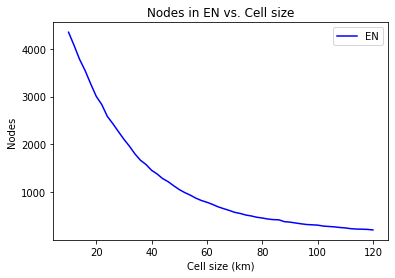

In [8]:
ax=dfdatosprof.plot(kind="line",x="tcel",y="nodos",color="blue",label="EN")

ax.set_title("Nodes in EN vs. Cell size")
ax.set_xlabel("Cell size (km)")
ax.set_ylabel("Nodes")

Text(0, 0.5, 'Average degree')

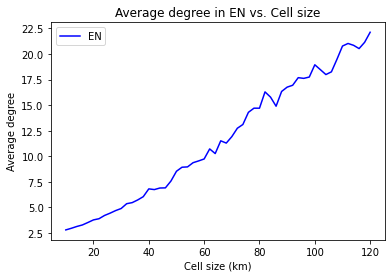

In [10]:
ax=dfdatosprof.plot(kind="line",x="tcel",y="grado",color="blue",label="EN")

ax.set_title("Average degree in EN vs. Cell size")
ax.set_xlabel("Cell size (km)")
ax.set_ylabel("Average degree")

Text(0, 0.5, 'Small-worldness')

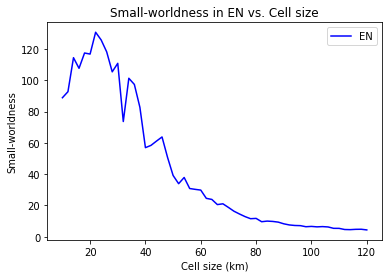

In [11]:
ax=dfdatosprof.plot(kind="line",x="tcel",y="smallworld",color="blue",label="EN")

ax.set_title("Small-worldness in EN vs. Cell size")
ax.set_xlabel("Cell size (km)")
ax.set_ylabel("Small-worldness")

In [ ]:

#plt.figure().set_figwidth(15)
plt.rcParams['figure.figsize'] = [10,17]

#dfdatosprof.plot(x='tcel',y=['medianenergianodos','entropia','cluster','path','grado','smallworld'],subplots=True)


#dfdatosprof.plot(x='entropia',y=['medianenergianodos','smallworld'],subplots=True)

dfdatosprof.plot(x='nodos',y=['medianenergianodos','smallworld','entropia'],subplots=True)

#df1.plot(x='tini',y=['energia','fractaldim'])
plt.show()


In [ ]:
dfdatosprof.plot(x='tcel',y=['medianenergianodos','entropia','grado','smallworld','nodos'],subplots=True)

In [ ]:
#dfdatosprof[dfdatosprof["tcel"]<200]

In [ ]:
dfdatosprof[["tcel","nodos"]].to_csv("celdasvsnodos-new.csv")

# Simulacion de redes de sismos

## Generacion de datos - corridas largas

La siguiente celda SOLAMENTE se corre una vez, para calcular los betas a partir del small-worldness.

In [ ]:
%%time

##################### DEMORA 9horas ##########################

nbetas=20
betas=[b for b in np.arange(0.1,1.01,0.1)]

#ntests=25

losdatos=[]
indices=dfdatosprof.tcel.values

for t in tamcel:
    nodos=dfdatosprof[dfdatosprof.tcel==t].nodos.values[0]
    grado=dfdatosprof[dfdatosprof.tcel==t].grado.values[0]
    #smallworld=smallworldness(grafos[ii])
    smallworld=dfdatosprof[dfdatosprof.tcel==t].smallworld.values[0]
    ii=np.where(indices == t)[0][0]
    prgrado=disprobgrado(grafos[ii])
            
    #nodos=caracredes.nodosprof
    #grado=caracredes.gradoprof
    #print(f"celda: {t} - nodos {nodos} grado {grado}")
    for b in betas:
        
        g=[nx.connected_watts_strogatz_graph(nodos,int(round(grado)),b,400) for i in range(nbetas)]
        print(f"celda: {t} - nodos {nodos} grado {grado} beta {b}")

        #i=0
        #while i < nbetas:
        #    sw=nx.watts_strogatz_graph(nodos,int(round(grado)),b)
        #    if nx.is_connected(sw):
        #        i=i+1
        #        g.append(sw)
        #d=[disestas(prgrado ,disprobgrado(g1)) for g1 in g]
        sws=[smallworldness(g1) for g1 in g]
        #losdatos.append([t,nodos,grado,smallworld,b,statistics.mean(d),statistics.stdev(d),statistics.mean(sws),statistics.stdev(sws),min(sws),max(sws)])
        losdatos.append([t,nodos,grado,smallworld,b,statistics.mean(sws),statistics.stdev(sws),min(sws),max(sws)])

#dflosdatos=pd.DataFrame(losdatos,columns=["tamcel","nodos","grado","smallworldness","beta","mean","stdev","mean-sw","stdev-sw","sw-min","sw-max"])
dflosdatos=pd.DataFrame(losdatos,columns=["tamcel","nodos","grado","smallworldness","beta","mean-sw","stdev-sw","sw-min","sw-max"])
dflosdatos["swdiff"]=dflosdatos.apply(lambda row: row["smallworldness"] - row["mean-sw"], axis=1)
dflosdatos["absswdiff"]=dflosdatos["swdiff"].abs().to_list()
dflosdatos.to_csv("datos-smallworldness-red-completa-new.csv")

In [ ]:
%%time

#dft3 queda con los valores de las redes watts-strogatz con el smallworldness más parecido;
#para sacar el beta a partir del smallworldness

dft3=pd.DataFrame(columns=dflosdatos.columns)
dft4=pd.DataFrame(columns=dflosdatos.columns)
for t in tamcel:
    dft=dflosdatos[dflosdatos["tamcel"]==t]
    dft=dft[dft["absswdiff"]==dft["absswdiff"].max()]
    dft4=pd.concat([dft4,dft],ignore_index=True)
    dft=dflosdatos[dflosdatos["tamcel"]==t]
    dft=dft[dft["absswdiff"]==dft["absswdiff"].min()]
    dft3=pd.concat([dft3,dft],ignore_index=True)
dfwork=dft3
dfwork.to_csv("datos-redes-smallworldness-catalogo-completo-new.csv")

#dfwork tiene datos de beta a partir de smallworldness.
#todo esto es a partir de datos en dflosdatos
#en dfdatosprof están datos de redes de sismos.
#en grafos las redes para cada tamano de celda.

#beta=0.5

ntests=100

#losdatos1=[]
indices=dfdatosprof.tcel.values

divergencias=[]
    
for index, linea in dfwork.iterrows():
    t=linea.tamcel
    print(f"inicia tamano {t}")
    nodos=linea.nodos
    grado=linea.grado
    cluster=dfdatosprof[dfdatosprof["tcel"]==t].cluster.values[0]
    path=dfdatosprof[dfdatosprof["tcel"]==t].path.values[0]
    entropia=dfdatosprof[dfdatosprof["tcel"]==t].entropia.values[0]
    between=dfdatosprof[dfdatosprof["tcel"]==t].meanbetween.values[0]
    ii=np.where(indices == t)[0][0]
    prgrado=disprobgrado(grafos[ii])
    
    beta=linea.beta
    # Se calculan redes aleatorias.
    print("inician tests")
    for i in range(ntests):
        rer1=nx.erdos_renyi_graph(nodos,grado/nodos)
        rer2=nx.erdos_renyi_graph(nodos,grado/nodos)
        rsw1=nx.connected_watts_strogatz_graph(nodos,int(round(grado)),beta,150)
        rsf=nx.barabasi_albert_graph(nodos,int(round(grado/2)))

        rer11=rer1.subgraph(max(nx.connected_components(rer1), key=len).copy())
        rer22=rer2.subgraph(max(nx.connected_components(rer2), key=len).copy())
        
        clsw=nx.average_clustering(rsw1)
        cler=nx.average_clustering(rer22)
        clsf=nx.average_clustering(rsf)

        psw=nx.average_shortest_path_length(rsw1)
        per=nx.average_shortest_path_length(rer22)
        psf=nx.average_shortest_path_length(rsf)
        
        er1=disprobgrado(rer1)
        er2=disprobgrado(rer2)
        
        sw1=disprobgrado(rsw1)
        sf=disprobgrado(rsf)

        entr2=dentropy(er2)
        entsw1=dentropy(sw1)
        entsf=dentropy(sf)

        
        b=list(nx.betweenness_centrality(rer2).values())
        betr2=np.mean(b)
        b=list(nx.betweenness_centrality(rsw1).values())
        betsw1=np.mean(b)
        b=list(nx.betweenness_centrality(rsf).values())
        betsf=np.mean(b)
        
        #print("disestas sw")
        divssw=disestas(sw1,er1)
        #print("disestas er")
        divser=disestas(er2,er1)
        #print("disestas sf")
        divssf=disestas(sf,er1)
        #print("disestas en")
        divsen=disestas(prgrado,er1)

        divensw1=disestas(prgrado,sw1)
        divensf=disestas(prgrado,sf)
        
        divergencias.append([t,grado,cluster,path,divsen,cler,per,divser,clsw,psw,divssw,beta,clsf,psf,divssf,divensw1,divensf,entropia,entr2,entsw1,entsf,between,betr2,betsw1,betsf])

    print(f"listo tamano {t}")

dfdivergencias=pd.DataFrame(divergencias,columns=["tcel","grado","cluster","path","DivEN","cler","per","DivER","clsw","psw","DivSW","beta","clsf","psf","DivSF","DivENSWsw","DivENSF","entropia","entrn","entsw1","entsf","betweeness","betr2","betsw1","betsf"])
dfdivergencias.to_csv("divergencias-catalogo-completo-new.csv")


Esta celda carga, para todos los tamaños de celda y todos los betas, los valores del small-worldness. Así mismo, las divergencias de ls redes de sismos vs. redes watts-strogatz generadas.

## Carga de datos para no hacer corridas largas - `dflosdatos`, `dfdivergencias`

Se cargan las divergencias.

In [8]:
dflosdatos=pd.read_csv("datos-smallworldness-red-completa-new.csv")
dfdivergencias=pd.read_csv("divergencias-catalogo-completo-new.csv")
dfwork=pd.read_csv("datos-redes-smallworldness-catalogo-completo-new.csv")

## Siguen los cálculos

In [9]:
%%time
#esto demora menos de un segundo.

#Datos promedio de divergencias
out=[]
for t in range(10,121,2):
    dtemp=dfdivergencias[dfdivergencias.tcel == t]
    
    divenmean=dtemp.DivEN.mean()
    divenstd=dtemp.DivEN.std()
    divermean=dtemp.DivER.mean()
    diverstd=dtemp.DivER.std()
    divswmean=dtemp.DivSW.mean()
    divswstd=dtemp.DivSW.std()
    beta=dtemp.beta.mean()
    divsfmean=dtemp.DivSF.mean()
    divsfstd=dtemp.DivSF.std()

    divenswswmean=dtemp.DivENSWsw.mean()
    divenswswstd=dtemp.DivENSWsw.std()
    divensfmean=dtemp.DivENSF.mean()
    divensfstd=dtemp.DivENSF.std()
    
    ent=dtemp.entropia.mean()
    entrnmean=dtemp.entrn.mean()
    entrnstd=dtemp.entrn.std()
    entswswmean=dtemp.entsw1.mean()
    entswswstd=dtemp.entsw1.std()
    entsfmean=dtemp.entsf.mean()
    entsfstd=dtemp.entsf.std()

    bet=dtemp.betweeness.mean()
    betrnmean=dtemp.betr2.mean()
    betrnstd=dtemp.betr2.std()
    betswswmean=dtemp.betsw1.mean()
    betswswstd=dtemp.betsw1.std()
    betsfmean=dtemp.betsf.mean()
    betsfstd=dtemp.betsf.std()

    cluster=dtemp.cluster.mean()
    cluermean=dtemp.cler.mean()
    cluerstd=dtemp.cler.std()
    cluswmean=dtemp.clsw.mean()
    cluswstd=dtemp.clsw.std()
    clusfmean=dtemp.clsf.mean()
    clusfstd=dtemp.clsf.std()
    
    path=dtemp.path.mean()
    patermean=dtemp.per.mean()
    paterstd=dtemp.per.std()
    patswmean=dtemp.psw.mean()
    patswstd=dtemp.psw.std()
    patsfmean=dtemp.psf.mean()
    patsfstd=dtemp.psf.std()


    out.append([t,divenmean,divenstd,
                divermean,diverstd,divswmean,divswstd,beta,divsfmean,divsfstd,
                divenswswmean,divenswswstd,divensfmean,divensfstd,
                ent,entrnmean,entrnstd,entswswmean,entswswstd,entsfmean,entsfstd,
                bet,betrnmean,betrnstd,betswswmean,betswswstd,betsfmean,betsfstd,
                cluster,cluermean,cluerstd,cluswmean,cluswstd,clusfmean,clusfstd,
                path,patermean,paterstd,patswmean,patswstd,patsfmean,patsfstd])
dfmeandivergencias=pd.DataFrame(out,columns=["tcel","divENmean","divENstd",
                                            "divERmean","divERstd","divSWmean","divSWstd","beta","divSFmean","divSFstd",
                                            "divENSWswmean","divENSWswstd","divENSFmean","divENSFstd",
                                            "ent","entERmean","entERstd","entSWswmean","entSWswstd","entSFmean","entSFstd",
                                            "bet","betERmean","betERstd","betSWswmean","betSWswstd","betSFmean","betSFstd",
                                            "cluster","cluERmean","cluERstd","cluSWswmean","cluSWswstd","cluSFmean","cluSFstd",
                                            "path","patERmean","patERstd","patSWswmean","patSWswstd","patSFmean","patSFstd"])

dfmeandivergencias["complejidad"]=dfmeandivergencias["divENmean"]*dfmeandivergencias.ent
dfmeandivergencias["compER"]=dfmeandivergencias["divERmean"]*dfmeandivergencias["entERmean"]
dfmeandivergencias["compSWsw"]=dfmeandivergencias["divSWmean"]*dfmeandivergencias["entSWswmean"]
dfmeandivergencias["compSF"]=dfmeandivergencias["divSFmean"]*dfmeandivergencias["entSFmean"]

dfmeandivergencias["difEN-ER"]=dfmeandivergencias["divENmean"]-dfmeandivergencias["divERmean"]
dfmeandivergencias["difEN-SW"]=dfmeandivergencias["divENmean"]-dfmeandivergencias["divSWmean"]
dfmeandivergencias["difEN-SF"]=dfmeandivergencias["divENmean"]-dfmeandivergencias["divSFmean"]

dfmeandivergencias.to_csv("dfmeandivergencias-new.csv")

dfmeandiferencias=dfmeandivergencias[["tcel","difEN-ER","difEN-SW","difEN-SF"]]

CPU times: user 332 ms, sys: 458 µs, total: 332 ms
Wall time: 390 ms


## Graficas

Text(0.5, 0, 'Cell size')

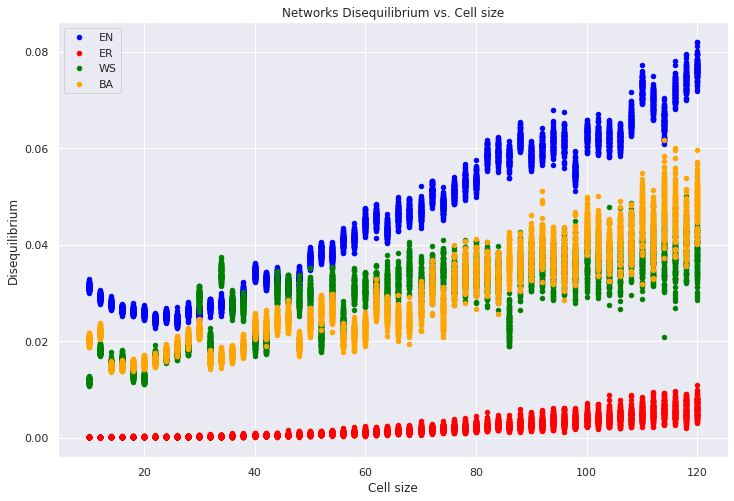

In [14]:
import seaborn as sns
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias.plot(kind="scatter",x="tcel",y="DivEN",color="blue",label="EN")
dfdivergencias.plot(kind="scatter",x="tcel",y="DivER",color="red",label="ER",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="DivSW",color="green",label="WS",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivSWdiv",color="lightgreen",label="WS2",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="DivSF",color="orange",label="BA",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWsw",color="gray",label="ENSWsw",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWdiv",color="lightgray",label="ENSWdiv",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSF",color="black",label="ENSF",ax=ax)


ax.set_title("Networks Disequilibrium vs. Cell size")
ax.set_ylabel("Disequilibrium")
ax.set_xlabel("Cell size")
#                    ,y=["DivEN","DivER","DivSW","DivSF"],kind='scatter')

Text(0.5, 0, 'Cell size')

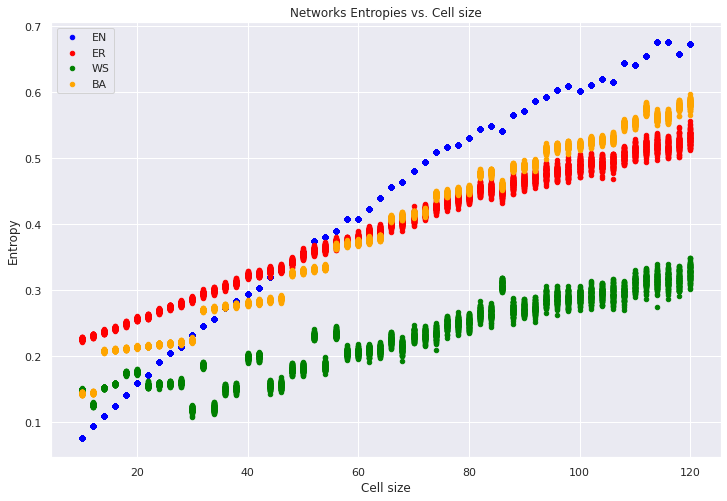

In [15]:
import seaborn as sns
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias.plot(kind="scatter",x="tcel",y="entropia",color="blue",label="EN")
dfdivergencias.plot(kind="scatter",x="tcel",y="entrn",color="red",label="ER",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="entsw1",color="green",label="WS",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="entsw2",color="lightgreen",label="SWdiv",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="entsf",color="orange",label="BA",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWsw",color="gray",label="ENSWsw",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWdiv",color="lightgray",label="ENSWdiv",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSF",color="black",label="ENSF",ax=ax)


ax.set_title("Networks Entropies vs. Cell size")
ax.set_ylabel("Entropy")
ax.set_xlabel("Cell size")
#                    ,y=["DivEN","DivER","DivSW","DivSF"],kind='scatter')

In [ ]:
import seaborn as sns
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias.plot(kind="scatter",x="tcel",y="path",color="blue",label="EN")
dfdivergencias.plot(kind="scatter",x="tcel",y="per",color="red",label="ER",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="psw",color="green",label="WS",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="pswdiv",color="lightgreen",label="WS2",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="psf",color="orange",label="BA",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWsw",color="gray",label="ENSWsw",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWdiv",color="lightgray",label="ENSWdiv",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSF",color="black",label="ENSF",ax=ax)


ax.set_title("Longitud promedio de caminos de las redes vs. tamaño de celdas")
ax.set_ylabel("Longitud promedio")
ax.set_xlabel("Tamaño de celda")
#                    ,y=["DivEN","DivER","DivSW","DivSF"],kind='scatter')

In [ ]:
import seaborn as sns
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias.plot(kind="scatter",x="tcel",y="cluster",color="blue",label="EN")
dfdivergencias.plot(kind="scatter",x="tcel",y="cler",color="red",label="ER",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="clsw",color="green",label="WS",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="clswdiv",color="lightgreen",label="WS2",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="clsf",color="orange",label="BA",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWsw",color="gray",label="ENSWsw",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWdiv",color="lightgray",label="ENSWdiv",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSF",color="black",label="ENSF",ax=ax)

ax.set_title("Coeficientes de clustering de las redes vs. tamaño de celdas")
ax.set_ylabel("Clustering")
ax.set_xlabel("Tamaño de celda")
#                    ,y=["DivEN","DivER","DivSW","DivSF"],kind='scatter')

In [9]:
dfdivergencias["complejidad"]=dfdivergencias["DivEN"]*dfdivergencias["entropia"]
dfdivergencias["comper"]=dfdivergencias["DivER"]*dfdivergencias["entrn"]
dfdivergencias["compsw1"]=dfdivergencias["DivSW"]*dfdivergencias["entsw1"]
#dfdivergencias["compsw2"]=dfdivergencias["DivSWdiv"]*dfdivergencias["entsw2"]
dfdivergencias["compsf"]=dfdivergencias["DivSF"]*dfdivergencias["entsf"]

In [ ]:
import seaborn as sns
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias.plot(kind="scatter",x="tcel",y="complejidad",color="blue",label="EN")
dfdivergencias.plot(kind="scatter",x="tcel",y="comper",color="red",label="ER",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="compsw1",color="green",label="WS",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="compsw2",color="lightgreen",label="WS2",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="compsf",color="orange",label="BA",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWsw",color="gray",label="ENSWsw",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWdiv",color="lightgray",label="ENSWdiv",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSF",color="black",label="ENSF",ax=ax)

ax.set_title("Complejidad de las redes vs. tamaño de celdas")
ax.set_ylabel("Complejidad")
ax.set_xlabel("Tamaño de celda")
#                    ,y=["DivEN","DivER","DivSW","DivSF"],kind='scatter')

Text(0.5, 0, 'Cell size')

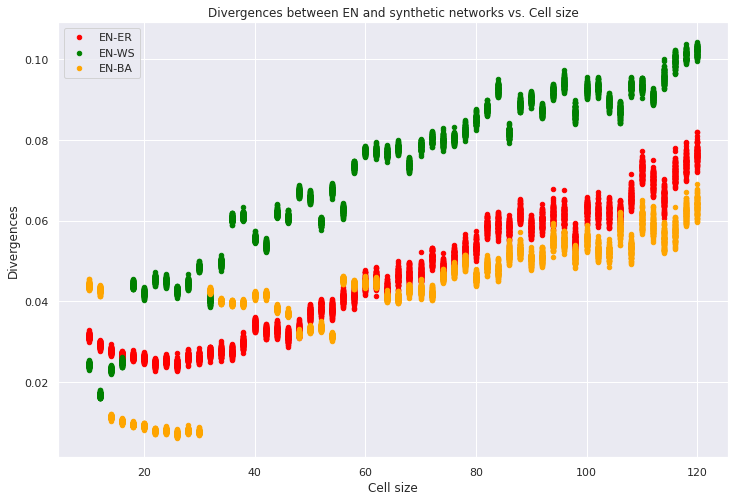

In [17]:
import seaborn as sns
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias.plot(kind="scatter",x="tcel",y="DivEN",color="red",label="EN-ER")
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivER",color="red",label="ER",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivSW",color="green",label="SWsw",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivSWdiv",color="lightgreen",label="SWdiv",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivSF",color="orange",label="SF",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWsw",color="green",label="EN-WS",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWdiv",color="lightgreen",label="EN-SW2",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSF",color="orange",label="EN-BA",ax=ax)


#ax.set_title("Divergencias entre las redes de sismos y las redes sintéticas vs. tamaño de celdas")
ax.set_title("Divergences between EN and synthetic networks vs. Cell size")
ax.set_ylabel("Divergences")
ax.set_xlabel("Cell size")

#                    ,y=["DivEN","DivER","DivSW","DivSF"],kind='scatter')

In [ ]:
#Grafica de boxplots para las divergencias

## DIVERGENCIAS ##
dfdiv1=dfdivergencias[["DivEN","tcel"]].assign(divergencia="EN")
dfdiv2=dfdivergencias[["DivER","tcel"]].assign(divergencia="ER")
dfdiv3=dfdivergencias[["DivSW","tcel"]].assign(divergencia="WS")
#dfdiv5=dfdivergencias[["DivSWdiv","tcel"]].assign(divergencia="SWdiv")
dfdiv4=dfdivergencias[["DivSF","tcel"]].assign(divergencia="BA")
columnas=["Divergence","CellSize","NetworkType"]
#dfdiv1.columns=["value","tcel","divergencia"]
dfdiv1.columns=columnas
dfdiv2.columns=columnas
dfdiv3.columns=columnas
dfdiv4.columns=columnas
#dfdiv5.columns=columnas
dfdivs = pd.concat([dfdiv1, dfdiv2, dfdiv3, dfdiv4])                                # CONCATENATE

#ax = sns.boxplot(x="tcel", y="value", hue="divergencia", data=dfdivs[dfdivs["tcel"]<100])  # RUN PLOT
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', "figure.figsize":(16, 12)})
#sns.set(rc={"figure.figsize":(16, 10)})

colores = {'EN': 'blue', 'ER': 'yellow', 'WS': 'green', 'BA': 'red'}

#sns.boxplot(x='group_var', y='values_var', data=df, palette=my_colors)

ax = sns.boxplot(x=columnas[1], y=columnas[0], hue=columnas[2], palette=colores, data=dfdivs[dfdivs[columnas[1]]<100], linewidth=0.5, fliersize=1)  # RUN PLOT
plt.xticks(rotation=45);
plt.show()

plt.clf()
plt.close()

In [ ]:
#grafico de promedios de divergencias
sns.set(rc={"figure.figsize":(8, 5)}) #width=8, height=4



#dfmeandivergencias.plot(x="tcel",y=["divENmean","divERmean","divSWmean","divSFmean"])

#fig, ax1 = plt.subplots(1,1,figsize=(16,9))

ax1=dfmeandivergencias.plot(kind='scatter', x="tcel", y="divENmean", color='blue', label="EN-ER")
ax2=dfmeandivergencias.plot(kind='scatter', x="tcel", y="divERmean", color='orange', label="ER", ax=ax1)
ax3=dfmeandivergencias.plot(kind='scatter', x="tcel", y="divSWmean", color='green', label="WS", ax=ax1)
ax4=dfmeandivergencias.plot(kind='scatter', x="tcel", y="divSFmean", color='red', label="BA", ax=ax1)

#ax6=dfmeandivergencias.plot(kind='scatter', x="tcel", y="divENSWswmean", color='green', label="EN-SW(sw)", ax=ax1)
#ax7=dfmeandivergencias.plot(kind='scatter', x="tcel", y="divENSWdivmean", color='lightgreen', label="EN-SW(div)", ax=ax1)
#ax8=dfmeandivergencias.plot(kind='scatter', x="tcel", y="divENSFmean", color='red', label="EN-SF", ax=ax1)

ax1.set_xlabel('Cell')
ax1.set_ylabel('div.')
#ax1.figsize(8,5)


In [ ]:
sns.set(rc={"figure.figsize":(8, 5)}) #width=8, height=4

dfmeandivergencias.plot(x='tcel',y=["difEN-ER","difEN-SW","difEN-SF"],subplots=False, color=["blue","green","red"])

In [ ]:
dfmeandiferencias[dfmeandiferencias["difEN-SW"]<0.0015]

In [ ]:
#grafico de promedios de clusters
sns.set(rc={"figure.figsize":(8, 5)}) #width=8, height=4

#dfmeandivergencias.plot(x="tcel",y=["divENmean","divERmean","divSWmean","divSFmean"])

#fig, ax1 = plt.subplots(1,1,figsize=(16,9))

ax1=dfmeandivergencias.plot(kind='scatter', x="tcel", y="cluster", color='blue', label="EN")
ax2=dfmeandivergencias.plot(kind='scatter', x="tcel", y="cluERmean", color='orange', label="ER", ax=ax1)
ax3=dfmeandivergencias.plot(kind='scatter', x="tcel", y="cluSWswmean", color='green', label="SW", ax=ax1)
ax4=dfmeandivergencias.plot(kind='scatter', x="tcel", y="cluSFmean", color='red', label="SF", ax=ax1)

ax1.set_xlabel('Cell')
ax1.set_ylabel('cluster.')
#ax1.figsize(8,5)


In [ ]:
#grafico de promedios de paths
sns.set(rc={"figure.figsize":(8, 5)}) #width=8, height=4

ax1=dfmeandivergencias.plot(kind='scatter', x="tcel", y="path", color='blue', label="EN")
ax2=dfmeandivergencias.plot(kind='scatter', x="tcel", y="patERmean", color='orange', label="ER", ax=ax1)
ax3=dfmeandivergencias.plot(kind='scatter', x="tcel", y="patSWswmean", color='green', label="SW", ax=ax1)
ax4=dfmeandivergencias.plot(kind='scatter', x="tcel", y="patSFmean", color='red', label="SF", ax=ax1)

ax1.set_xlabel('Cell')
ax1.set_ylabel('path.')


scatter plot 3D - x: tamcelda, y: cluster, z: path. Color: tipo de red.

In [ ]:
#grafico de promedios de betweeness
sns.set(rc={"figure.figsize":(8, 5)}) #width=8, height=4

ax1=dfmeandivergencias.plot(kind='scatter', x="tcel", y="bet", color='blue', label="EN")
ax2=dfmeandivergencias.plot(kind='scatter', x="tcel", y="betERmean", color='orange', label="ER", ax=ax1)
ax3=dfmeandivergencias.plot(kind='scatter', x="tcel", y="betSWswmean", color='green', label="SW", ax=ax1)
ax4=dfmeandivergencias.plot(kind='scatter', x="tcel", y="betSFmean", color='red', label="SF", ax=ax1)

ax1.set_xlabel('Cell')
ax1.set_ylabel('Betweeness.')
#ax1.figsize(8,5)

In [ ]:
#grafico de promedios de entropia
sns.set(rc={"figure.figsize":(8, 5)}) #width=8, height=4



#dfmeandivergencias.plot(x="tcel",y=["divENmean","divERmean","divSWmean","divSFmean"])

#fig, ax1 = plt.subplots(1,1,figsize=(16,9))

ax1=dfmeandivergencias.plot(kind='scatter', x="tcel", y="ent", color='blue', label="EN")
ax2=dfmeandivergencias.plot(kind='scatter', x="tcel", y="entERmean", color='orange', label="ER", ax=ax1)
ax3=dfmeandivergencias.plot(kind='scatter', x="tcel", y="entSWswmean", color='green', label="WS", ax=ax1)
ax4=dfmeandivergencias.plot(kind='scatter', x="tcel", y="entSFmean", color='red', label="BA", ax=ax1)

ax1.set_xlabel('Cell')
ax1.set_ylabel('Entropia.')
#ax1.figsize(8,5)

In [ ]:
#grafico de promedios de complejidad
sns.set(rc={"figure.figsize":(8, 5)}) #width=8, height=4



#dfmeandivergencias.plot(x="tcel",y=["divENmean","divERmean","divSWmean","divSFmean"])

#fig, ax1 = plt.subplots(1,1,figsize=(16,9))

ax1=dfmeandivergencias.plot(kind='scatter', x="tcel", y="complejidad", color='blue', label="EN")
ax2=dfmeandivergencias.plot(kind='scatter', x="tcel", y="compER", color='orange', label="ER", ax=ax1)
ax3=dfmeandivergencias.plot(kind='scatter', x="tcel", y="compSWsw", color='green', label="SW", ax=ax1)
ax4=dfmeandivergencias.plot(kind='scatter', x="tcel", y="compSF", color='red', label="SF", ax=ax1)

ax1.set_xlabel('Cell')
ax1.set_ylabel('complejidad.')
#ax1.figsize(8,5)

(0.0, 1.0)

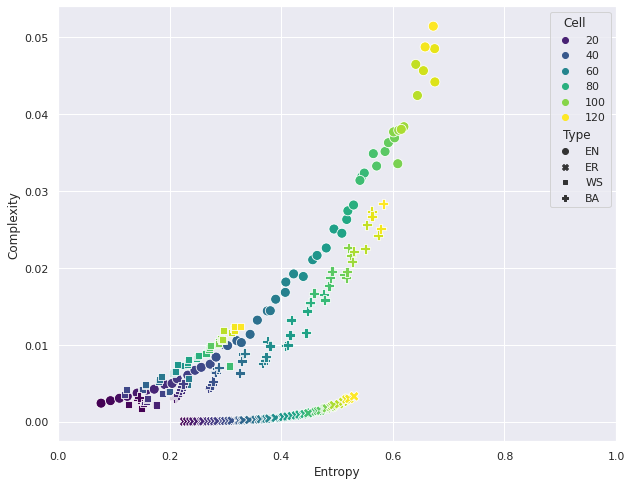

In [19]:
dfdiv1=dfmeandivergencias[["tcel","cluster","path","ent","complejidad"]].assign(tipo="EN")
dfdiv2=dfmeandivergencias[["tcel","cluERmean","patERmean","entERmean","compER"]].assign(tipo="ER")
dfdiv3=dfmeandivergencias[["tcel","cluSWswmean","patSWswmean","entSWswmean","compSWsw"]].assign(tipo="WS")
dfdiv5=dfmeandivergencias[["tcel","cluSFmean","patSFmean","entSFmean","compSF"]].assign(tipo="BA")

columnas=["Cell","Clustering","PathLength","Entropy","Complexity","Type"]
dfdiv1.columns=columnas
dfdiv2.columns=columnas
dfdiv3.columns=columnas
dfdiv5.columns=columnas
dfentscomps = pd.concat([dfdiv1, dfdiv2, dfdiv3, dfdiv5])








sns.set(rc={"figure.figsize":(10, 8)})

graf=sns.scatterplot(data=dfentscomps,
                x='Entropy',
               y='Complexity',
               style='Type',
               hue='Cell',
               palette='viridis',
                s=100
               )
graf.set_xlim(0,1)



In [ ]:
import plotly.express as px
#dfentscomps
fig = px.scatter_3d(dfentscomps, x='Entropia', y='Complejidad', z='tcel',
              #color='petal_length', size='petal_length', size_max=18,
              color='Tipo',symbol='Tipo', opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

# Pruebas de ML

In [9]:
%%time

ltmin=-5
lnmin=-82
ltmax=13
lnmax=-66

gr2km=111

largo=((((ltmax-ltmin)*gr2km)//100)+(1 if ((ltmax-ltmin)*gr2km)%100 > 1 else 0))*100
ancho=((((lnmax-lnmin)*gr2km)//100)+(1 if ((lnmax-lnmin)*gr2km)%100 > 1 else 0))*100

fullcatalogo=pd.read_csv("./catalogo-usgs-20231011.csv", parse_dates=["time"])

#Tiempo de inicio. Los eventos anteriores se descartan.
tini=UTCDateTime("1973-01-01T00:00:00Z")
#Magnitud mínima para calcular la distribución GR
mc=3.9
#Magnitud máxima para calcular la distribución GR
mmax=7.5
#La magnitud de completitud es la magnitud mínima mas este delta.
dmc=0.2

#Se crea el catálogo
catalogo=fullcatalogo[["time","latitude","longitude","depth","mag"]]

#se crea una nueva columna en los datos con el epoch de la fecha. Esto para poder comparar.
catalogo["epochs"]=(catalogo["time"]-pd.Timestamp("1970-01-01T00:00:00Z"))//pd.Timedelta('1s')

#se filtra el catálogo por fechas
catalogo=catalogo[(catalogo["epochs"]>tini)&((catalogo["latitude"]<ltmax)&(catalogo["latitude"]>ltmin))&((catalogo["longitude"]>lnmin)&(catalogo["longitude"]<lnmax))]

#Se crea la distribución de magnitudes vs. N de eventos.
magnitudes=catalogo.mag.values
magnitudes=magnitudes[magnitudes>=mc]
magnitudes=magnitudes[magnitudes<mmax]
magnitudes.sort()
magnitudes

num_events = np.arange(1, len(magnitudes)+1)
cumulative_dist = num_events[::-1] #/num_events[-1]

#Se ajusta una curva a la distribución de magnitudes.
popt, pcov = curve_fit(gutenberg_richter, magnitudes, np.log10(cumulative_dist))

parama=popt[0]
y=gutenberg_richter(magnitudes,parama,popt[1])
listamags=np.arange(1.05,8.5,0.1)

listacants=[]
for lmag in listamags:
    l=(catalogo.mag > lmag)
    listacants.append(sum(l))
    
#Se crea un dataframe con las magnitudes y cantidad de eventos.
gutrich=pd.DataFrame(listamags,columns=["Mag"])
gutrich.insert(len(gutrich.columns),"N",listacants)
nlogs=np.log10(gutrich.N)
gutrich.insert(len(gutrich.columns),"logN",nlogs)
gutrich["logN"]=gutrich['logN'].replace(-np.inf,0)

mmin=mc+dmc-0.001

#Tamaño de celdas, para construir las redes de sismos
tamcel=[r for r in range(10,122,2)]

#se crea una nueva columna en los datos con el epoch de la fecha. Esto para poder comparar.
catalogo["epochs"]=(catalogo["time"]-pd.Timestamp("1970-01-01T00:00:00Z"))//pd.Timedelta('1s')

#un catálogo con los datos posteriores a la fecha inicial
catalogo=catalogo[((catalogo["epochs"]>tini) & (catalogo["mag"] > mmin))&((catalogo["latitude"]<ltmax)&(catalogo["latitude"]>ltmin))&((catalogo["longitude"]>lnmin)&(catalogo["longitude"]<lnmax))]

#se calcula la energía sismica de los eventos, y se inserta en la tabla como columna "energia". La formula usada
#es tomada de Stein, pagina 273. OJO! en stein, la formula es en ergios, por eso se debe restar un 7 para que quede
#en julios.
e=[]
for i, lin in catalogo.iterrows():
    e.append(math.pow(10,4.8+1.5*lin["mag"]))

catalogo.insert(len(catalogo.columns),"energia",e)

print("se tiene catalogo completo")


#CALCULO DE GRAFOS
grafos=[]
disprobs=[]
gammas=[]

limsup=80
liminf=6

for tcel in tamcel:
    cp=[]
    for i, lin in catalogo.iterrows():
        cp.append(calculaceldaprof(ltmin,lnmin,tcel,gr2km,ancho,largo,lin["latitude"],lin["longitude"],lin["depth"]))

    grafoprof=nx.Graph()
    tam=len(cp)
    for j in range(1,tam):
        grafoprof.add_edge(cp[j-1],cp[j])

    catalogo.insert(len(catalogo.columns),"celda"+str(tcel),cp)
    grafos.append(grafoprof)
    d=disprobgrado(grafoprof)
    x=[i+liminf+1 for i in range(limsup)]
    y=[d[i+liminf] for i in range(limsup)]
    popt, pcov = curve_fit(myExpFunc, x, y)
    gammas.append([tcel,popt[1],limsup,liminf])

    disprobs.append(d)

dfgammas=pd.DataFrame(gammas,columns=["tcel","gamma","limsup","liminf"])

print("se tiene catalogo completo con identificacion de celdas")


<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/danileo/miniconda3/envs/redessismos/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


se tiene catalogo completo
se tiene catalogo completo con identificacion de celdas
CPU times: user 27.7 s, sys: 214 ms, total: 27.9 s
Wall time: 28 s


In [10]:
dfdatosprof=pd.read_csv("datos-redes-profundidad-catalogocompleto-new.csv")
dftcelsall=pd.read_csv("datosceldasredessismos.csv")

In [10]:
catalogo

,time,latitude,longitude,depth,mag,epochs,energia,celda10,celda12,celda14,...,celda102,celda104,celda106,celda108,celda110,celda112,celda114,celda116,celda118,celda120
229,1973-01-05 00:39:48.200000+00:00,0.6830,-80.0180,36.000,4.7,95042388,7.079458e+11,3888443375,1875307831,674871613,...,108,106,87,86,84,82,80,79,78,77
231,1973-01-07 01:04:57.200000+00:00,6.8560,-73.0740,160.000,5.1,95216697,2.818383e+12,20738327744,8126316485,3711774122,...,121339,112334,104153,96708,89902,83700,78027,72830,68060,63663
232,1973-01-11 06:50:51.800000+00:00,12.1740,-76.8650,33.000,4.5,95583051,3.548134e+11,3888466269,1250223756,674883338,...,323,317,294,289,284,279,257,253,249,230
233,1973-01-11 21:03:48.600000+00:00,6.8390,-72.9260,156.000,4.2,95634228,1.258925e+11,19442183741,8126316486,3711773995,...,121339,112334,104153,96708,89902,83700,78027,72830,68060,63663
234,1973-01-13 07:47:27.800000+00:00,-0.4590,-77.9570,25.000,4.4,95759247,2.511886e+11,2592297053,1250206346,337437567,...,75,74,72,71,70,69,67,66,65,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7983,2023-09-28 06:28:04.373000+00:00,1.1982,-78.8230,52.807,4.1,1695882484,8.912509e+10,6480732296,2500408596,1012305044,...,109,107,105,104,102,100,98,81,79,78
7984,2023-10-01 22:42:19.522000+00:00,7.4182,-77.0063,44.668,4.4,1696200139,2.511886e+11,5184600732,1875317159,1012311358,...,235,231,226,206,202,197,194,175,172,170
7985,2023-10-05 20:55:06.784000+00:00,0.6912,-77.9134,10.000,4.8,1696539306,1.000000e+12,1296155390,7838,5818,...,110,108,89,88,86,85,82,81,80,79
7986,2023-10-08 23:35:05.063000+00:00,8.8156,-77.1671,25.935,4.6,1696808105,5.011872e+11,2592315602,1250219103,337446959,...,270,248,243,238,217,213,210,206,188,185


In [34]:
catalogo.to_csv("catalogo-conceldas.csv")

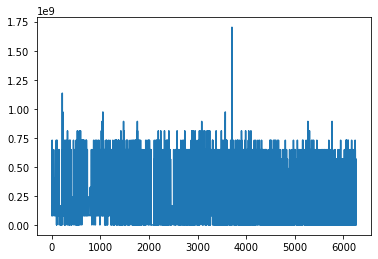

In [19]:
x=[i for i in range(6262)]
plt.plot(x,catalogo.celda20)

In [37]:
import sys
sys.version_info


redes convolucionales
redes tensores
capas densas
transformers

red recurrente: LSTM

PCA.



sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)

In [32]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

AttributeError: module 'numpy' has no attribute 'typeDict'

In [185]:
%%time
labelcol=[]
ncols=4
nrows=6

dcol=(lnmax-lnmin)/ncols
drow=(ltmax-ltmin)/nrows

for i, row in catalogo.iterrows():
    lat=row.latitude
    lon=row.longitude
    dlt=lat-ltmin
    dln=lon-lnmin
    i=(int)(dlt/drow)
    j=(int)(dln/dcol)
    label=(i*ncols)+j
    #print(ltmin,lnmin,lat,lon,dlt,dln,drow,dcol,i,j,label)
    labelcol.append(label)
catalogo["label"]=labelcol


CPU times: user 399 ms, sys: 13 µs, total: 399 ms
Wall time: 398 ms


In [187]:
catalogo["label"].min()

0

In [167]:
%%time
#el tamaño que se elige para hacer pruebas de ML es 50.
tamano=50
indice=tamcel.index(tamano)
dftcelwork=dftcelsall[dftcelsall['tcel']==tamano]
for n in grafos[indice].nodes:
    #print(n)
    #for llave in llaves:
    dct=dftcelwork[dftcelwork['celda']==n].to_dict('records')[0]
    for br in ['tcel','mode','celda',]:
        del dct[br]
    dct1={n:dct}
    nx.set_node_attributes(grafos[20],dct1)


CPU times: user 1.32 s, sys: 8.04 ms, total: 1.33 s
Wall time: 1.67 s


In [195]:
%%time
grafossplits=[]
nantes=40
#print("catalogo",len(catalogo))
veccaracs=[]
for i in range(len(catalogo)-nantes-1):
    #print("i",i,nantes)
    #label=catalogo.loc[i+nantes,"label"]
    #print("label",label)
    grafotemp=nx.Graph()
    for j in range(1,nantes):
        grafotemp.add_edge(catalogo.iloc[i+j-1]["celda"+str(tamano)],catalogo.iloc[i+j]["celda"+str(tamano)])
    energia=0
    for k in range(nantes):
        energia=energia+catalogo.iloc[i+k]["energia"]
    lenergia=np.log(energia)
    for n in grafotemp.nodes:
        dct=dftcelwork[dftcelwork['celda']==n].to_dict('records')[0]
        for br in ['tcel','mode','celda',]:
            del dct[br]
        dct1={n:dct}
        nx.set_node_attributes(grafotemp,dct1)
    
    grafossplits.append(grafotemp)

    ########################3
    #clusterings
    clusttemp=nx.average_clustering(grafotemp)
            
    #average path length
    pathstemp=nx.average_shortest_path_length(grafotemp)
            
    #numero de bordes
    nedgestemp=grafotemp.number_of_edges()
            
    #numero de nodos
    nodostemp=nx.number_of_nodes(grafotemp)
            
    #Grado promedio
    gradstemp=gradprom( grafotemp )
            
    #distribucion de grado
    prgradtemp=disprobgrado(grafotemp)
            
    #Entropia
    enttemp=dentropy(prgradtemp)
            
    #Smallworldness
    smallworldtemp=smallworldness(grafotemp)
            
    #betweenness centrality
    betweentemp=list(nx.betweenness_centrality(grafotemp).values())
    mbetweentemp=np.mean([float(d) for d in betweentemp])

    veccaracs.append([nodostemp,nedgestemp,gradstemp,clusttemp,pathstemp,enttemp,smallworldtemp,mbetweentemp,lenergia])

labels=catalogo.label[nantes+1:]

CPU times: user 5min 23s, sys: 103 ms, total: 5min 23s
Wall time: 5min 24s


In [188]:
labels=catalogo.label[nantes+1:]

In [170]:
dfveccaracs=pd.DataFrame(veccaracs,columns=["nodos","edges","grad","clus","path","ent","sw","bet","energia"])

In [172]:
dfveccaracs

,nodos,edges,grad,clus,path,ent,sw,bet,energia
0,15,19,2.533333,0.080952,2.695238,0.359823,0.518110,0.130403,31.398042
1,14,18,2.571429,0.088095,2.692308,0.294352,0.497790,0.141026,31.414202
2,15,18,2.400000,0.000000,2.876190,0.374435,0.000000,0.144322,31.356523
3,15,18,2.400000,0.000000,3.028571,0.359823,0.000000,0.156044,31.352249
4,16,18,2.250000,0.000000,3.883333,0.303637,0.000000,0.205952,31.351358
...,...,...,...,...,...,...,...,...,...
6236,14,16,2.285714,0.086735,2.593407,0.386417,0.653944,0.132784,30.834324
6237,15,16,2.133333,0.080952,3.104762,0.402619,0.655242,0.161905,30.838525
6238,15,16,2.133333,0.080952,3.076190,0.402619,0.661327,0.159707,30.827718
6239,15,16,2.133333,0.080952,3.161905,0.402619,0.643400,0.166300,30.232423


In [107]:
labels.values.astype(int)

array([10, 10, 10, ...,  5, 14,  4])

In [189]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
labels1=labels.values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(veccaracs, labels1, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [190]:
y_train

array([ 8,  5,  8, ..., 14,  0, 16])

In [194]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

rmodel = RandomForestClassifier(criterion='gini',n_estimators=250)
rmodel.fit(X_train_scaled, y_train)

y_pred = rmodel.predict(X_test_scaled)

print('Accuracy', accuracy_score(y_test,y_pred))
print('Precision', precision_score(y_test,y_pred,average= 'weighted'))
print('Recall', recall_score(y_test,y_pred,average= 'weighted'))
#print('F1-score', f1_score(y_test,y_pred,average= 'weighted'))

Accuracy 0.221777421938
Precision 0.209706894002
Recall 0.221777421938


In [141]:
from collections import Counter
print(Counter(labels1).keys())
print(Counter(labels1).values())


dict_keys([19, 6, 7, 1, 21, 0, 20, 24, 27, 26, 25, 14, 12, 18, 28, 13, 34, 2, 33, 15, 32, 30, 31, 35, 8, 3, 10, 29])
dict_values([556, 488, 446, 482, 742, 460, 938, 142, 235, 178, 530, 100, 290, 50, 41, 215, 77, 48, 90, 19, 45, 21, 7, 7, 1, 1, 1, 1])


In [45]:
print('Accuracy', accuracy_score(y_test,y_pred))
print('Precision', precision_score(y_test,y_pred,average= 'weighted'))
print('Recall', recall_score(y_test,y_pred,average= 'weighted'))


Accuracy 0.233787029624
Precision 0.216929056381
Recall 0.233787029624


In [31]:
y_pred

array([ 7.,  0.,  4., ...,  6.,  5.,  3.])

In [73]:
grafossplits[0].nodes[437]

{'mean': 34320087050300.0,
 'median': 354813389234.0,
 'sum': 1544403917260000.0,
 'latitude': 0.610495555556,
 'longitude': -79.9910733333,
 'depth': 20.6334222222,
 'degree': 49.0,
 'clustering': 0.167437557817,
 'betweeness': 0.00796891952643,
 'eccentricity': 4.0,
 'nevents': 45.0}

In [69]:
for n in grafossplits[0].nodes:
    dct=dftcelwork[dftcelwork['celda']==n].to_dict('records')[0]
    for br in ['tcel','mode','celda',]:
        del dct[br]
    dct1={n:dct}
    nx.set_node_attributes(grafotemp,dct1)

In [61]:
labels=catalogo.label[nantes+1:]

In [23]:
ltmin=-5
lnmin=-82
ltmax=13
lnmax=-66

gr2km=111


ncols=4
nrows=6

dcol=(lnmax-lnmin)/ncols
drow=(ltmax-ltmin)/nrows


ln=lnmin
i=0
while ln < lnmax:
    ln=lnmin+(i*drow)
    #print(ln)
    lt=ltmin
    j=0
    while lt < ltmax:
        lt=ltmin+(j*dcol)
        region=(i*drow)+j
        print(ln,lt,region)
        j=j+1
    i=i+1


-82.0 -5.0 0.0
-82.0 -1.0 1.0
-82.0 3.0 2.0
-82.0 7.0 3.0
-82.0 11.0 4.0
-82.0 15.0 5.0
-79.0 -5.0 3.0
-79.0 -1.0 4.0
-79.0 3.0 5.0
-79.0 7.0 6.0
-79.0 11.0 7.0
-79.0 15.0 8.0
-76.0 -5.0 6.0
-76.0 -1.0 7.0
-76.0 3.0 8.0
-76.0 7.0 9.0
-76.0 11.0 10.0
-76.0 15.0 11.0
-73.0 -5.0 9.0
-73.0 -1.0 10.0
-73.0 3.0 11.0
-73.0 7.0 12.0
-73.0 11.0 13.0
-73.0 15.0 14.0
-70.0 -5.0 12.0
-70.0 -1.0 13.0
-70.0 3.0 14.0
-70.0 7.0 15.0
-70.0 11.0 16.0
-70.0 15.0 17.0
-67.0 -5.0 15.0
-67.0 -1.0 16.0
-67.0 3.0 17.0
-67.0 7.0 18.0
-67.0 11.0 19.0
-67.0 15.0 20.0
-64.0 -5.0 18.0
-64.0 -1.0 19.0
-64.0 3.0 20.0
-64.0 7.0 21.0
-64.0 11.0 22.0
-64.0 15.0 23.0


In [11]:
#dftcelsall=pd.read_csv("")
dfdatosprof=pd.read_csv("datos-redes-profundidad-catalogocompleto-new.csv")
dftcelsall=pd.read_csv("datosceldasredessismos.csv")

In [12]:
dftcelsall=dftcelsall.drop(['Unnamed: 0','count'],axis=1)

In [21]:
%%time
#el tamaño que se elige para hacer pruebas de ML es 50.
tamano=50
indice=tamcel.index(tamano)
dftcelwork=dftcelsall[dftcelsall['tcel']==tamano]
for n in grafos[indice].nodes:
    #print(n)
    #for llave in llaves:
    dct=dftcelwork[dftcelwork['celda']==n].to_dict('records')[0]
    for br in ['tcel','mode','celda',]:
        del dct[br]
    dct1={n:dct}
    nx.set_node_attributes(grafos[20],dct1)


CPU times: user 1.03 s, sys: 172 µs, total: 1.03 s
Wall time: 1.03 s


In [23]:
grafos[20].nodes[437]

{'mean': 34320087050300.0,
 'median': 354813389234.0,
 'sum': 1544403917260000.0,
 'latitude': 0.610495555556,
 'longitude': -79.9910733333,
 'depth': 20.6334222222,
 'degree': 49.0,
 'clustering': 0.167437557817,
 'betweeness': 0.00796891952643,
 'eccentricity': 4.0,
 'nevents': 45.0}

In [ ]:
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from sklearn.model_selection import train_test_split

In [ ]:
nx.jaccard_coefficient(grafos[20],)

In [64]:
grafos[20].nodes

NodeView((437, 6239048, 1380, 6239049, 369, 800, 2080644, 2080315, 6238354, 2079440, 6238939, 2080134, 801, 2079589, 225, 2079404, 2080535, 2079656, 6238863, 4159497, 2080498, 4159534, 2080165, 765, 727, 764, 802, 4158985, 2079588, 2080129, 4158952, 766, 6238390, 221, 4158739, 2080177, 2079439, 973, 6239085, 6239156, 4158777, 983, 628, 1160, 989, 294, 75, 655, 2080275, 907, 1196, 2079691, 4158774, 1180, 6238718, 2080066, 6238353, 1216, 4159685, 2080320, 2079765, 401, 56, 117, 2079374, 1430, 957, 2080133, 4158849, 4159612, 2079696, 185, 2080168, 2079366, 4158984, 4158813, 4158876, 2079948, 2080176, 2079584, 919, 6239013, 2079513, 2080138, 1018, 982, 946, 1017, 804, 1019, 981, 1054, 2080346, 2080347, 10397733, 1055, 6239040, 4158733, 1429, 774, 8318046, 6238243, 4159864, 2079838, 2079619, 2080096, 2079591, 1142, 636, 2079963, 600, 39, 6238285, 4158810, 2080098, 2080056, 547, 1253, 545, 4159059, 2079991, 4158806, 2080284, 980, 4158887, 2080250, 6239084, 937, 945, 2080507, 1143, 2079412, 2

# FIN de notebook. Lo que sigue son pruebas.

In [ ]:
c,p= fpdfclusterbetween(grafos[20],bw)

In [21]:
%%time
bw=0.001
pdfcluster=[]
#pdfbetween=[]
eclusters=[]
#ebetweens=[]
for i in range(len(grafos)):
    g=grafos[i]
    dcl=np.array(list(nx.clustering(g).values()))
    #dbt=np.array(list(nx.betweenness_centrality(g).values()))
    modelc=KernelDensity(kernel='gaussian', bandwidth=bw)
    #modelb=KernelDensity(kernel='gaussian', bandwidth=bw)
    modelc.fit(dcl[:,None])
    #modelb.fit(dbt[:,None])
    
    xcl=np.linspace(dcl.min()-bw/2,dcl.max()+bw/2,100)
    vcl = xcl.reshape((len(xcl), 1))
    probcl = modelc.score_samples(vcl)
    eprobcl = np.exp(probcl)
    s=eprobcl.sum()
    neprobcl=eprobcl/s
    eclusters.append(dentropy(neprobcl))
    pdfcluster.append(neprobcl)

    #xbt=np.linspace(dbt.min()-bw/2,dbt.max()+bw/2,100)
    #vbt = xbt.reshape((len(xcl), 1))
    #probbt = modelb.score_samples(vbt)
    #eprobbt = np.exp(probbt)
    #s=eprobbt.sum()
    #neprobbt=eprobbt/s
    #ebetweens.append(dentropy(neprobbt))
    #pdfbetween.append(neprobbt)
    print("listo ",i)
    

listo  0
listo  1
listo  2
listo  3
listo  4
listo  5
listo  6
listo  7
listo  8
listo  9
listo  10
listo  11
listo  12
listo  13
listo  14
listo  15
listo  16
listo  17
listo  18
listo  19
listo  20
listo  21
listo  22
listo  23
listo  24
listo  25
listo  26
listo  27
listo  28
listo  29
listo  30
listo  31
listo  32
listo  33
listo  34
listo  35
listo  36
listo  37
listo  38
listo  39
listo  40
listo  41
listo  42
listo  43
listo  44
listo  45
listo  46
listo  47
listo  48
listo  49
listo  50
listo  51
listo  52
listo  53
listo  54
listo  55
CPU times: user 6.87 s, sys: 1.17 s, total: 8.04 s
Wall time: 33.3 s


In [22]:
%%time
eclusters=[]
#ebetweens=[]
for i in range(len(grafos)):
    neprobcl=pdfcluster[i]
    eclusters.append(dentropy(neprobcl))
    #neprobbt=pdfbetween[i]
    #ebetweens.append(dentropy(neprobbt))
    print("listo ",i)

listo  0
listo  1
listo  2
listo  3
listo  4
listo  5
listo  6
listo  7
listo  8
listo  9
listo  10
listo  11
listo  12
listo  13
listo  14
listo  15
listo  16
listo  17
listo  18
listo  19
listo  20
listo  21
listo  22
listo  23
listo  24
listo  25
listo  26
listo  27
listo  28
listo  29
listo  30
listo  31
listo  32
listo  33
listo  34
listo  35
listo  36
listo  37
listo  38
listo  39
listo  40
listo  41
listo  42
listo  43
listo  44
listo  45
listo  46
listo  47
listo  48
listo  49
listo  50
listo  51
listo  52
listo  53
listo  54
listo  55
CPU times: user 6.18 ms, sys: 318 µs, total: 6.5 ms
Wall time: 6.57 ms


In [ ]:
dfdivergencias.columns

In [23]:
dfdatosprof["entropiacluster"]=eclusters
#dfdatosprof["entropiabetween"]=ebetweens

In [ ]:
dfdatosprof.columns

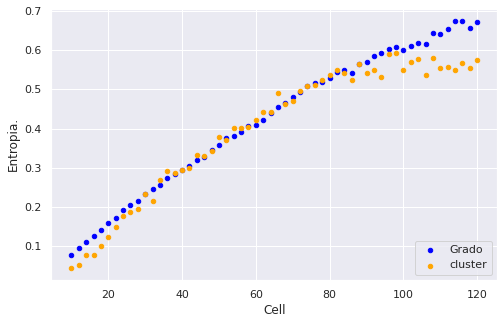

In [24]:
#GRAFICA CON BW=0.5. Dejarla para comparar.
sns.set(rc={"figure.figsize":(8, 5)}) #width=8, height=4

#dfmeandivergencias.plot(x="tcel",y=["divENmean","divERmean","divSWmean","divSFmean"])

#fig, ax1 = plt.subplots(1,1,figsize=(16,9))

ax1=dfdatosprof.plot(kind='scatter', x="tcel", y="entropia", color='blue', label="Grado")
ax2=dfdatosprof.plot(kind='scatter', x="tcel", y="entropiacluster", color='orange', label="cluster", ax=ax1)
#ax3=dfdatosprof.plot(kind='scatter', x="tcel", y="entropiabetween", color='green', label="between", ax=ax1)
#ax4=dfmeandivergencias.plot(kind='scatter', x="tcel", y="compSF", color='red', label="SF", ax=ax1)

ax1.set_xlabel('Cell')
ax1.set_ylabel('Entropia.')
plt.legend(loc='lower right')
#ax1.figsize(8,5)

In [ ]:
## NEW!!! CON BW=0.001
sns.set(rc={"figure.figsize":(8, 5)}) #width=8, height=4

#dfmeandivergencias.plot(x="tcel",y=["divENmean","divERmean","divSWmean","divSFmean"])

#fig, ax1 = plt.subplots(1,1,figsize=(16,9))

ax1=dfdatosprof.plot(kind='scatter', x="tcel", y="entropia", color='blue', label="Grado")
ax2=dfdatosprof.plot(kind='scatter', x="tcel", y="entropiacluster", color='orange', label="cluster", ax=ax1)
ax3=dfdatosprof.plot(kind='scatter', x="tcel", y="entropiabetween", color='green', label="between", ax=ax1)
#ax4=dfmeandivergencias.plot(kind='scatter', x="tcel", y="compSF", color='red', label="SF", ax=ax1)

ax1.set_xlabel('Cell')
ax1.set_ylabel('Entropia.')
plt.legend(loc='lower right')
#ax1.figsize(8,5)

In [29]:
%%time

#dfwork tiene datos de beta a partir de smallworldness.
#todo esto es a partir de datos en dflosdatos
#en dfdatosprof están datos de redes de sismos.
#en grafos las redes para cada tamano de celda.

#beta=0.5

ntests1=50
#bw=0.001
#losdatos1=[]
indices=dfdatosprof.tcel.values

divergencias1=[]
    
for index, linea in dfwork.iterrows():
    t=int(linea.tamcel)
    print(f"inicia tamano {t}")
    nodos=int(linea.nodos)
    grado=linea.grado
    print(f"inicia tamano {t} - nodos {nodos}")
    cluster=dfdatosprof[dfdatosprof["tcel"]==t].cluster.values[0]
    path=dfdatosprof[dfdatosprof["tcel"]==t].path.values[0]
    entropia=dfdatosprof[dfdatosprof["tcel"]==t].entropia.values[0]
    #between=dfdatosprof[dfdatosprof["tcel"]==t].meanbetween.values[0]
    entcluster=dfdatosprof[dfdatosprof["tcel"]==t].entropiacluster.values[0]
    #entbetween=dfdatosprof[dfdatosprof["tcel"]==t].entropiabetween.values[0]
    
    ii=np.where(indices == t)[0][0]
    prcluster=pdfcluster[ii]
    #prbetween=pdfbetween[ii]
    
    beta=linea.beta
    # Se calculan redes aleatorias.
    print("inician tests")
    for i in range(ntests1):
        rer1=nx.erdos_renyi_graph(nodos,grado/nodos)
        rer2=nx.erdos_renyi_graph(nodos,grado/nodos)
        rsw=nx.connected_watts_strogatz_graph(nodos,int(round(grado)),beta,150)
        rsf=nx.barabasi_albert_graph(nodos,int(round(grado/2)))

        rer11=rer1.subgraph(max(nx.connected_components(rer1), key=len).copy())
        rer22=rer2.subgraph(max(nx.connected_components(rer2), key=len).copy())
        
        #pcer1, pber1=fpdfclusterbetween(rer11,bw)
        #pcer2, pber2=fpdfclusterbetween(rer22,bw)
        #pcsw, pbsw=fpdfclusterbetween(rsw,bw)
        #pcsf, pbsf=fpdfclusterbetween(rsf,bw)

        pcer1 =fpdfcluster(rer11,bw)
        pcer2 =fpdfcluster(rer22,bw)
        pcsw =fpdfcluster(rsw,bw)
        pcsf =fpdfcluster(rsf,bw)

        epcer1=dentropy(pcer1)
        epcer2=dentropy(pcer2)
        #epber1=dentropy(pber1)
        #epber2=dentropy(pber2)

        epcsw=dentropy(pcsw)
        epcsf=dentropy(pcsf)
        #epbsw=dentropy(pbsw)
        #epbsf=dentropy(pbsf)

        #b=list(nx.betweenness_centrality(rer2).values())
        #betr2=np.mean(b)
        #b=list(nx.betweenness_centrality(rsw).values())
        #betsw1=np.mean(b)
        #b=list(nx.betweenness_centrality(rsf).values())
        #betsf=np.mean(b)
        
        #print("disestas sw")
        divecsw=disestas(pcsw,pcer1)
        #divebsw=disestas(pbsw,pber1)

        divecer=disestas(pcer2,pcer1)
        #diveber=disestas(pber2,pber1)

        divecsf=disestas(pcsf,pcer1)
        #divebsf=disestas(pbsf,pber1)

        divecen=disestas(prcluster,pcer1)
        #diveben=disestas(prbetween,pber1)

        divecensw=disestas(prcluster,pcsw)
        #divebensw=disestas(prbetween,pbsw)

        divecensf=disestas(prcluster,pcsf)
        #divebensf=disestas(prbetween,pbsf)

        #divergencias1.append([t,grado,cluster,path,entropia,
        #                      entcluster,divecen,entbetween,diveben,
        #                      epcer1,divecer,epber1,diveber,
        #                      epcsw,divecsw,epbsw,divebsw,
        #                      epcsf,divecsf,epbsf,divecsf,
        #                      divecensw,divebensw,divecensf,divebensf])

        divergencias1.append([t,grado,cluster,path,entropia,
                              entcluster,divecen,
                              epcer1,divecer,
                              epcsw,divecsw,
                              epcsf,divecsf,
                              divecensw,divecensf])

    print(f"listo tamano {t}")

#dfdivergencias1=pd.DataFrame(divergencias1,columns=["tcel","grado","cluster","path","entropia",
#                                                "entclen","divclen","entbeten","divbeten",
#                                                "entcler","divcler","entbeter","divbeter",
#                                                "entclsw","divclsw","entbetsw","divbetsw",
#                                                "entclsf","divclsf","entbetsf","divbetsf",
#                                                "divclensw","divbetensw","divclensf","divbetensf"])
#dfdivergencias1.to_csv("divergencias-clustering-betweeness-catalogo-completo-new"+str(bw)+".csv")

dfdivergencias1=pd.DataFrame(divergencias1,columns=["tcel","grado","cluster","path","entropia",
                                                "entclen","divclen",
                                                "entcler","divcler",
                                                "entclsw","divclsw",
                                                "entclsf","divclsf",
                                                "divclensw","divclensf"])
dfdivergencias1.to_csv("divergencias-clustering-catalogo-completo-new"+str(bw)+".csv")


inicia tamano 10
inicia tamano 10 - nodos 4345
inician tests
listo tamano 10
inicia tamano 12
inicia tamano 12 - nodos 4070
inician tests
listo tamano 12
inicia tamano 14
inicia tamano 14 - nodos 3777
inician tests
listo tamano 14
inicia tamano 16
inicia tamano 16 - nodos 3543
inician tests
listo tamano 16
inicia tamano 18
inicia tamano 18 - nodos 3267
inician tests
listo tamano 18
inicia tamano 20
inicia tamano 20 - nodos 3007
inician tests
listo tamano 20
inicia tamano 22
inicia tamano 22 - nodos 2835
inician tests
listo tamano 22
inicia tamano 24
inicia tamano 24 - nodos 2588
inician tests
listo tamano 24
inicia tamano 26
inicia tamano 26 - nodos 2435
inician tests
listo tamano 26
inicia tamano 28
inicia tamano 28 - nodos 2271
inician tests
listo tamano 28
inicia tamano 30
inicia tamano 30 - nodos 2109
inician tests
listo tamano 30
inicia tamano 32
inicia tamano 32 - nodos 1964
inician tests
listo tamano 32
inicia tamano 34
inicia tamano 34 - nodos 1802
inician tests
listo tamano 34

In [13]:
dfdivergencias1=pd.read_csv("divergencias-clustering-betweeness-catalogo-completo-new"+str(bw)+".csv")

In [ ]:
dfdivergencias1.columns

Text(0.5, 0, 'Tamaño de celda')

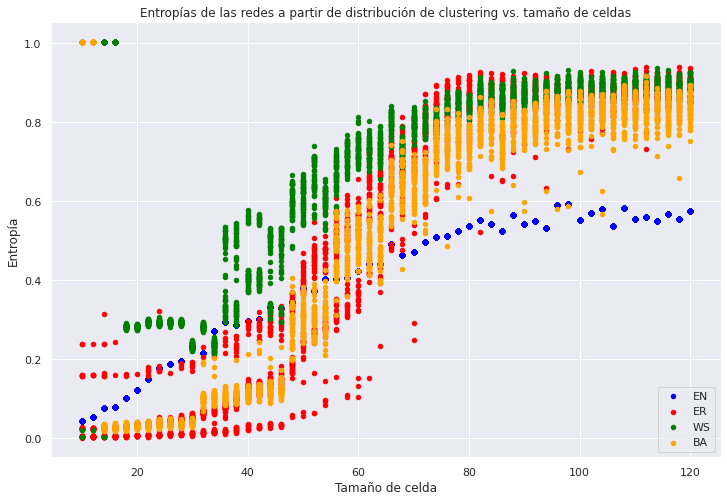

In [30]:
import seaborn as sns
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias1.plot(kind="scatter",x="tcel",y="entclen",color="blue",label="EN")
dfdivergencias1.plot(kind="scatter",x="tcel",y="entcler",color="red",label="ER",ax=ax)
dfdivergencias1.plot(kind="scatter",x="tcel",y="entclsw",color="green",label="WS",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="entsw2",color="lightgreen",label="SWdiv",ax=ax)
dfdivergencias1.plot(kind="scatter",x="tcel",y="entclsf",color="orange",label="BA",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWsw",color="gray",label="ENSWsw",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWdiv",color="lightgray",label="ENSWdiv",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSF",color="black",label="ENSF",ax=ax)


ax.set_title("Entropías de las redes a partir de distribución de clustering vs. tamaño de celdas")
ax.set_ylabel("Entropía")
ax.set_xlabel("Tamaño de celda")
#                    ,y=["DivEN","DivER","DivSW","DivSF"],kind='scatter')

Text(0.5, 0, 'Tamaño de celda')

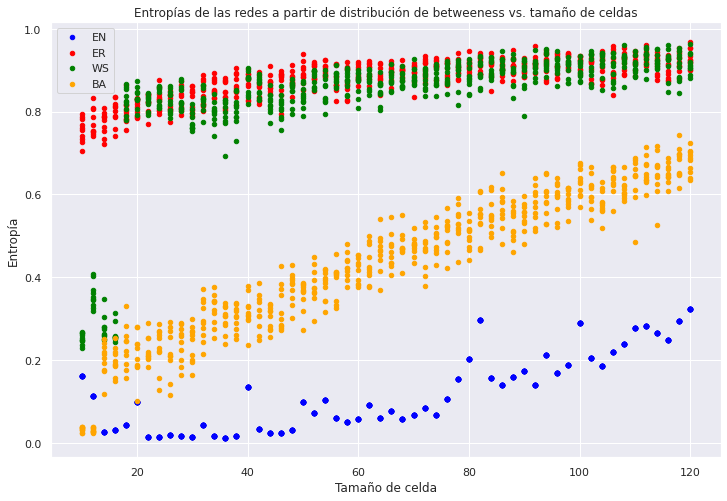

In [15]:
import seaborn as sns
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias1.plot(kind="scatter",x="tcel",y="entbeten",color="blue",label="EN")
dfdivergencias1.plot(kind="scatter",x="tcel",y="entbeter",color="red",label="ER",ax=ax)
dfdivergencias1.plot(kind="scatter",x="tcel",y="entbetsw",color="green",label="WS",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="entsw2",color="lightgreen",label="SWdiv",ax=ax)
dfdivergencias1.plot(kind="scatter",x="tcel",y="entbetsf",color="orange",label="BA",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWsw",color="gray",label="ENSWsw",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWdiv",color="lightgray",label="ENSWdiv",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSF",color="black",label="ENSF",ax=ax)


ax.set_title("Entropías de las redes a partir de distribución de betweeness vs. tamaño de celdas")
ax.set_ylabel("Entropía")
ax.set_xlabel("Tamaño de celda")
#                    ,y=["DivEN","DivER","DivSW","DivSF"],kind='scatter')

In [ ]:
dfdivergencias1.columns

Text(0.5, 0, 'Tamaño de celda')

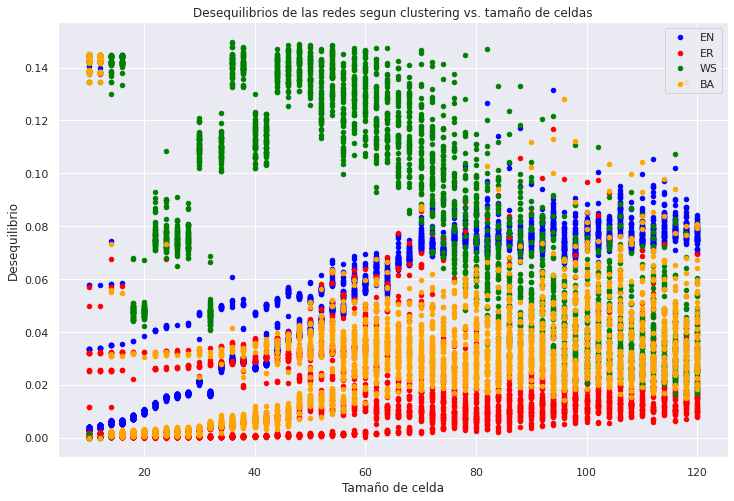

In [31]:
import seaborn as sns
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias1.plot(kind="scatter",x="tcel",y="divclen",color="blue",label="EN")
dfdivergencias1.plot(kind="scatter",x="tcel",y="divcler",color="red",label="ER",ax=ax)
dfdivergencias1.plot(kind="scatter",x="tcel",y="divclsw",color="green",label="WS",ax=ax)
dfdivergencias1.plot(kind="scatter",x="tcel",y="divclsf",color="orange",label="BA",ax=ax)

ax.set_title("Desequilibrios de las redes segun clustering vs. tamaño de celdas")
ax.set_ylabel("Desequilibrio")
ax.set_xlabel("Tamaño de celda")
#                    ,y=["DivEN","DivER","DivSW","DivSF"],kind='scatter')

Text(0.5, 0, 'Tamaño de celda')

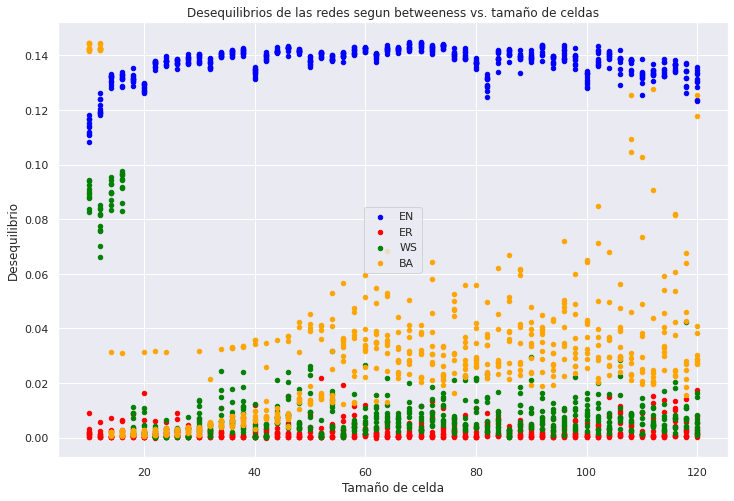

In [17]:
import seaborn as sns
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias1.plot(kind="scatter",x="tcel",y="divbeten",color="blue",label="EN")
dfdivergencias1.plot(kind="scatter",x="tcel",y="divbeter",color="red",label="ER",ax=ax)
dfdivergencias1.plot(kind="scatter",x="tcel",y="divbetsw",color="green",label="WS",ax=ax)
dfdivergencias1.plot(kind="scatter",x="tcel",y="divbetsf",color="orange",label="BA",ax=ax)

ax.set_title("Desequilibrios de las redes segun betweeness vs. tamaño de celdas")
ax.set_ylabel("Desequilibrio")
ax.set_xlabel("Tamaño de celda")
#                    ,y=["DivEN","DivER","DivSW","DivSF"],kind='scatter')

In [ ]:
dfdivergencias1.columns

Text(0.5, 0, 'Tamaño de celda')

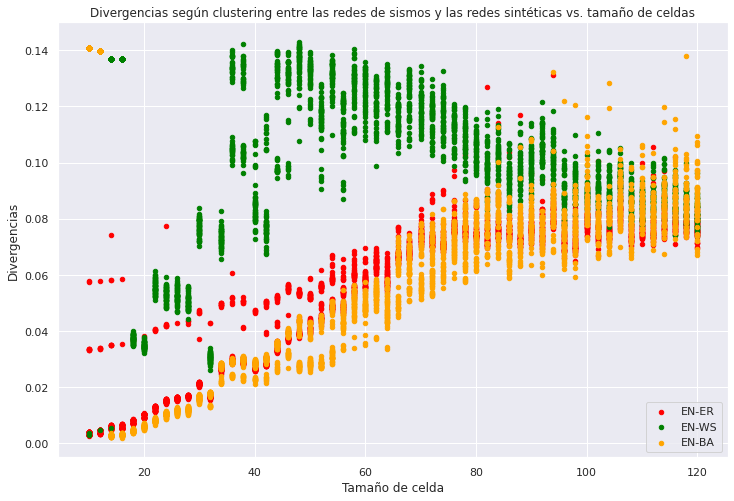

In [32]:
import seaborn as sns
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias1.plot(kind="scatter",x="tcel",y="divclen",color="red",label="EN-ER")
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivER",color="red",label="ER",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivSW",color="green",label="SWsw",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivSWdiv",color="lightgreen",label="SWdiv",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivSF",color="orange",label="SF",ax=ax)
dfdivergencias1.plot(kind="scatter",x="tcel",y="divclensw",color="green",label="EN-WS",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWdiv",color="lightgreen",label="EN-SW2",ax=ax)
dfdivergencias1.plot(kind="scatter",x="tcel",y="divclensf",color="orange",label="EN-BA",ax=ax)


ax.set_title("Divergencias según clustering entre las redes de sismos y las redes sintéticas vs. tamaño de celdas")
ax.set_ylabel("Divergencias")
ax.set_xlabel("Tamaño de celda")


Text(0.5, 0, 'Tamaño de celda')

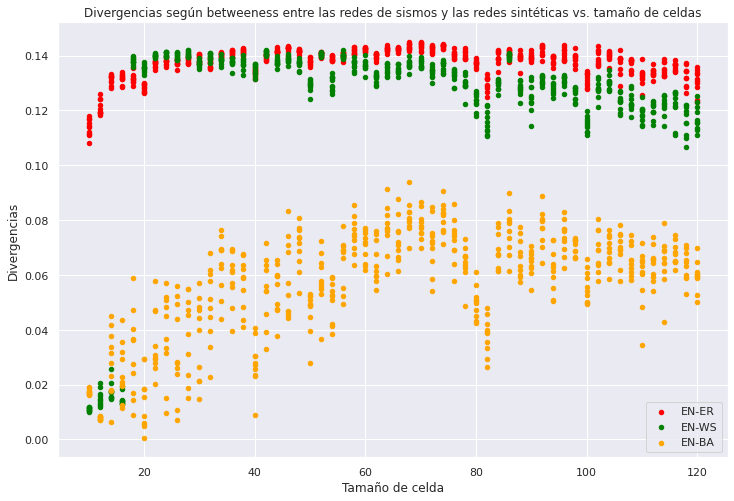

In [19]:
import seaborn as sns
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias1.plot(kind="scatter",x="tcel",y="divbeten",color="red",label="EN-ER")
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivER",color="red",label="ER",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivSW",color="green",label="SWsw",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivSWdiv",color="lightgreen",label="SWdiv",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivSF",color="orange",label="SF",ax=ax)
dfdivergencias1.plot(kind="scatter",x="tcel",y="divbetensw",color="green",label="EN-WS",ax=ax)
#dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWdiv",color="lightgreen",label="EN-SW2",ax=ax)
dfdivergencias1.plot(kind="scatter",x="tcel",y="divbetensf",color="orange",label="EN-BA",ax=ax)


ax.set_title("Divergencias según betweeness entre las redes de sismos y las redes sintéticas vs. tamaño de celdas")
ax.set_ylabel("Divergencias")
ax.set_xlabel("Tamaño de celda")


In [ ]:
sum(lnep)

In [ ]:
dentropy(neprob)

In [ ]:
plt.fill_between(xt, lnep, alpha=0.5)
plt.plot(lista, np.full_like(lista, -0.01), '|k', markeredgewidth=1)
#plt.ylim(-0.02, 0.22)

In [ ]:
from scipy.stats import norm
# Kernel Density Estimator using gaussian kernel
X = lista[:, np.newaxis]
model = KernelDensity(kernel='gaussian',
                      bandwidth=0.2)
model.fit(X[:, None])
new_data = np.linspace(-5, 5, 1000)
density = np.exp(model.score_samples(new_data[:, None]))
# print(new_data)
# Plot the densities
plt.plot(new_data, density, '-',
         color='red')
plt.xlabel('Data')
plt.ylabel('Density')
plt.title('Kernel Density Estimator using Gaussian kernel')
plt.show()

In [ ]:
dentropy(lista)

In [ ]:
dftcels=[pd.pivot_table(catalogo,values="energia",index=["celda"+str(t)],aggfunc={'energia':[np.mean,np.sum,np.median,stats.mode,'count']}) for t in tamcel]

In [ ]:
import plotly.express as px

x1=dfmeandivergencias.ent.values
y1=dfmeandivergencias.complejidad.values
z1=dfmeandivergencias.tcel.values

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x1, y1, z1, color = "blue")
plt.title("ent-complejidad-tcel")
 
# show plot
plt.show()

In [ ]:

dfmeandivergencias.plot.scatter(x='ent', y='complejidad', c='tcel', cmap='viridis',title="Redes sismos", xticks=[i/10 for i in range (0,11,1)],xlabel="entropia",sharex=False)
dfmeandivergencias.plot.scatter(x='entERmean', y='compER', c='tcel', cmap='viridis',title="Erdos-Renyi", xticks=[i/10 for i in range (0,11,1)],xlabel="entropia",sharex=False)
dfmeandivergencias.plot.scatter(x='entSWswmean', y='compSWsw', c='tcel', cmap='viridis',title="Watts-Strogatz (sw)", xticks=[i/10 for i in range (0,11,1)],xlabel="entropia",sharex=False)
dfmeandivergencias.plot.scatter(x='entSFmean', y='compSF', c='tcel', cmap='viridis',title="Barabasi-Albert", xticks=[i/10 for i in range (0,11,1)],xlabel="entropia",sharex=False)

#ax.set_xlabel('X-axis label')
#ax.set_xticks(df.index)
#ax.set_xticklabels(df['x'])

plt.show()

#plt.scatter(dfmeandivergencias.ent, dfmeandivergencias.complejidad, s=100, c=dfmeandivergencias.tamcel, cmap='gray')

In [ ]:
[i for i in range(0,11,1)]

In [ ]:
dfmeans

In [ ]:
import plotly.express as px
fig=px.scatter_3d(
    dfmeans,
    x="tcel",
    y="cluster",
    z="path",
    color="tipo",
    symbol="tipo",
    width=1000, height=700
    
)
fig.show()


In [ ]:
import plotly.express as px
fig=px.scatter(
    x=[x1,x1,x1,x1],
    y=[y1,y2,y3,y4],
    z=[z1,z2,z3,z4],
    color=['blue','green','red','orange']
    #type="scatter"
)
fig.show()

In [ ]:
ax.scat

In [ ]:
%%time


col="cluster"
y="promenergianodos"
#txtx="Average Energy per number of nodes"
txtx=col
dtm1=dfdatosprof[[y,"tcel",col]]
#dtm1=dfdatos[["twin","tamcel","energiaporgrado"]]
dtmap=dtm1.groupby(["twin","tcel"],as_index=False).mean()

ax=sns.heatmap(dtmap.pivot(index="twin",columns="tcel",values=col))
#ax.set_title(col)
ax.set(title=txtx+" (mean)", xlabel="Cell sizes (km)", ylabel="Time windows (months)")

plt.show()
#col="energia"
#dtm1=dfdatos[["twin","tamcel","energiaporgrado"]]
dtmap1=dtm1.groupby(["twin","tcel"],as_index=False).std()

ax=sns.heatmap(dtmap1.pivot(index="twin",columns="tcel",values=col))
ax.set(title=txtx+" (std. dev.)", xlabel="Cell sizes (km)", ylabel="Time windows (months)")

plt.show()

In [ ]:
dfdatosprof

In [ ]:

import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from scipy.stats import entropy


from dateutil.relativedelta import relativedelta

import cartopy
import cartopy.crs as ccrs

import pygmt

from sklearn.tree import DecisionTreeRegressor
import graphviz #libreria de garficos que se une a matplotlib
from io import StringIO #entrada y salida de datos png
from IPython.display import Image  #graficar con colores
from sklearn.tree import export_graphviz #crear graficos de Tree

import six   # sklearn.externals.six
import sys   # sklearn.externals.six
import pydotplus  #exportar graficos 


In [ ]:
def calculacelda(ltmin,lnmin,tmcel,gr2km,ancho,largo,lat,lon):
    idx=ancho/tmcel
    i=int((lat-ltmin)*gr2km/tmcel)
    j=i*idx
    
    k=int((lon-lnmin)*gr2km/tmcel)
    return int(k+j+1)


def dentropy(v):
    v1=[i*math.log(i) for i in list(filter(lambda x: x>0, v))]
    s1=-sum(v1)/math.log(len(v)-1)
    return s1

def disprobgrado(grafo):
    m=nx.adjacency_matrix(grafo)
    v=[0 for i in range (m.shape[0])]
    v1=[0 for i in range (m.shape[0])]
    for i in range (m.shape[1]):
        i1=m[i].todense().sum()
        v[i1-1]=v[i1-1]+1
    tod=sum(v)
    for i in range(m.shape[1]):
        v1[i]=v[i]/tod
    return v1

def disestas(p1,p2):
    e1=dentropy([(p1[i]+p2[i])/2 for i in range(len(p1))])
    e2=(dentropy(p1)+dentropy(p2))/2
    return e1-e2

def smallworldness(g):
    n=nx.number_of_nodes(g)
    gp=gradprom(g)
    c=nx.average_clustering(g)
    p=nx.average_shortest_path_length(g)
    sw=c*n*np.log(n)/(p*gp*np.log(gp))
    return sw
    
def mapacat(cata1):
    region=[min(cata1["longitude"])-1, max(cata1["longitude"])+1, min(cata1["latitude"])-1, max(cata1["latitude"])+1]

    fig=pygmt.Figure()
    #plt.figure(fignum)
    #plt.figure=pygmt.Figure()
    fig.basemap(region=region, projection="M8i", frame=True)
    #plt.figure.basemap(region=region, projection="M8i", frame=True)

        #fig.coast(land='lightbrown',water="lightblue")
    fig.coast(shorelines="1/1p,200",borders="1/1p,100",water="lightblue",land="240/240/240")
    #_=coast(shorelines="1/1p,200",borders="1/1p,100",water="lightblue",land="240/240/240")
    #plt.figure.coast(shorelines="1/1p,200",borders="1/1p,100",water="lightblue",land="240/240/240")
    fig.plot(x=cata1["longitude"],y=cata1["latitude"],sizes=0.01*(2 ** cata1["mag"]) ,style="cc",color="red",pen="black")
    #_=plot(x=cata1["longitude"],y=cata1["latitude"],sizes=0.01*(2 ** cata1["mag"]) ,style="cc",color="red",pen="black")
    #plt.figure.plot(x=cata1["longitude"],y=cata1["latitude"],sizes=0.01*(2 ** cata1["mag"]) ,style="cc",color="red",pen="black")
    #fig.show()
    return(fig)


def normalizacol(df,col):
    res=(df[col]-df[col].min())/(df[col].max()-df[col].min())
    return res

def normalizacolgrupo(df,col,tw,tc):
    df1=df[ (df["twin"]==tw) & (df["tcel"]==tc)]
    res=(df1[col]-df1[col].min())/(df1[col].max()-df1[col].min())
    return res

def calculaceldascoods(ltmin,lnmin,tmcel,gr2km,ancho,largo):
    ltmax=ltmin+largo/gr2km
    lnmax=lnmin+ancho/gr2km
    d=tmcel/gr2km
    lt1=ltmin+(d/2)
    ln1=lnmin+(d/2)
    #print(lt1,ln1,d)
    o=[]
    for lt in np.arange(lt1,ltmax,d):
        for ln in np.arange(ln1,lnmax,d):
            c=calculacelda(ltmin,lnmin,tmcel,gr2km,ancho,largo,lt,ln)
            #print(c,ln,lt)
            o.append([c,ln,lt])
    return o



def calculaceldascoodsprof(ltmin,lnmin,tmcel,gr2km,ancho,largo,prof):
    ltmax=ltmin+largo/gr2km
    lnmax=lnmin+ancho/gr2km
    d=tmcel/gr2km
    lt1=ltmin+(d/2)
    ln1=lnmin+(d/2)
    #print(lt1,ln1,d)
    o=[]
    for p in np.arange(0,prof,tmcel):
        for lt in np.arange(lt1,ltmax,d):
            for ln in np.arange(ln1,lnmax,d):
                c=calculaceldaprof(ltmin,lnmin,tmcel,gr2km,ancho,largo,lt,ln,p)
                #print(c,ln,lt)
                o.append([c,ln,lt,p])
    return o


def calculaceldascoodst(ltmin,lnmin,tmcel,gr2km,ancho,largo,tiempo):
    ltmax=ltmin+largo/gr2km
    lnmax=lnmin+ancho/gr2km
    d=tmcel/gr2km
    lt1=ltmin+(d/2)
    ln1=lnmin+(d/2)
    #print(lt1,ln1,d)
    o=[]
    for lt in np.arange(lt1,ltmax,d):
        for ln in np.arange(ln1,lnmax,d):
            c=calculacelda(ltmin,lnmin,tmcel,gr2km,ancho,largo,lt,ln)
            #print(c,ln,lt)
            o.append([c,ln,lt,tiempo])
    return o


In [ ]:
#for t in tamcel:
#    caracredes=dfdatosprof[dfdatosprof.tcel==t]
#    print(f"caracredes: {caracredes.tcel.values[0]}, t: {t}")

#indices=dfdatosprof.tcel.values
#np.where(indices == 10)[0][0]
nbetas

In [ ]:
dfdatosprof[dfdatosprof.tcel==10].nodosprof.values[0]

In [ ]:
int(round(2.8))

In [ ]:
grtest=nx.watts_strogatz_graph(3837,2,0.4)

In [ ]:
prtest=disprobgrado(grtest)
[p*3837 for p in prtest]


In [ ]:
nx.average_clustering(grtest)

In [ ]:
nx.draw(grtest)

In [ ]:
dflosdatos[dflosdatos["tamcel"]==10].to_csv("dfdatos-10km.csv")

In [ ]:
dfdatosprof.columns

In [ ]:
dfdatosprof.plot.line(x='cluster',y='entropia')

In [ ]:
dflosdatos[dflosdatos["tamcel"]==20].plot.line(x='beta',y='mean')

In [ ]:
#dflosdatos[dflosdatos["tamcel"]==20]

In [ ]:

        
#                    swdivp.append(statistics.mean(d))
#                    swdivs.append(statistics.stdev(d))
#                    sws=[smallworldness(g1) for g1 in g]
#                    swswp.append(statistics.mean(sws))
#                    swsws.append(statistics.stdev(sws))
                    #gsw.append(g)
#                absolutos=np.absolute(swswp-smallworld)
#            
#                bt=np.where(absolutos==np.amin(absolutos))[0][0]
#            
#                bt2=swdivp.index(min(swdivp))



In [ ]:
dflosdatos[dflosdatos["tamcel"]==10]

In [ ]:
dflosdatos

In [ ]:
dft3[dft3["tamcel"]>19].plot.line(x="tamcel",y="beta")

En estas divergencias, que muestran el valor máximo, se ve que son muy bajos los valores. Por lo tanto, teniendo en cuenta que estas son las mayores divergencias y que están limitadas por `1`, se escoge un valor de 0.5 como probabilidad de de rewiring.

In [ ]:
dfwork=dft3[dft3["tamcel"]>19]
dfwork.to_csv("datos-redes-smallworldness-catalogo-completo.csv")
#dfwork

In [ ]:
dfwork=pd.read_csv("datos-redes-smallworldness-catalogo-completo.csv")

In [ ]:
dfdatosprof[["tcel","nodos","edges","grado","cluster","path","entropia","smallworld","meanbetween"]].to_csv("dataframe-redes-prof.csv")

In [ ]:
#for index, linea in dfwork.iterrows():
#    #print(linea)
#    t=linea.tamcel
#    nodos=linea.nodos
#    grado=linea.grado
#    print(f"t {t}, nodos {nodos}, grado {grado}")
#dfwork
dfdatosprof[dfdatosprof["tcel"]==10].path.values[0]

In [ ]:
t=22
linea=dfwork[dfwork["tamcel"]==t]
print(f"inicia tamano {t}")
nodos=linea.nodos.values[0]
grado=linea.grado.values[0]
cluster=dfdatosprof[dfdatosprof["tcel"]==t].cluster.values[0]
path=dfdatosprof[dfdatosprof["tcel"]==t].path.values[0]
#nodos=dfwork[dfwork.tamcel==t].nodos.values[0]
#grado=dfdatosprof[dfdatosprof.tcel==t].grado.values[0]
ii=np.where(indices == t)[0][0]
prgrado=disprobgrado(grafos[ii])

#beta=dfwork[dft3["tamcel"]==t]
beta=linea.beta


In [ ]:

# Se calculan redes aleatorias.
rer1=nx.erdos_renyi_graph(nodos,grado/nodos)
rer2=nx.erdos_renyi_graph(nodos,grado/nodos)
rsf=nx.barabasi_albert_graph(nodos,int(round(grado/2)))

rer11=rer1.subgraph(max(nx.connected_components(rer1), key=len).copy())
rer22=rer2.subgraph(max(nx.connected_components(rer2), key=len).copy())

clsw=nx.average_clustering(rsw1)
cler=nx.average_clustering(rer22)
clsf=nx.average_clustering(rsf)

psw=nx.average_shortest_path_length(rsw1)
per=nx.average_shortest_path_length(rer22)
psf=nx.average_shortest_path_length(rsf)

er1=disprobgrado(rer1)
er2=disprobgrado(rer2)

sw1=disprobgrado(rsw1)
sf=disprobgrado(rsf)

#divssw=[disestas(sw1[g],er1[g]) for g in range(ntests)]
#divser=[disestas(er2[g],er1[g]) for g in range(ntests)]
#divssf=[disestas(sf[g],er1[g]) for g in range(ntests)]
#divsen=[disestas(prgrado,er1[g]) for g in range(ntests)]

print("disestas sw")
divssw=disestas(sw1,er1)
print("disestas er")
divser=disestas(er2,er1)
print("disestas sf")
divssf=disestas(sf,er1)
print("disestas en")
divsen=disestas(prgrado,er1)




In [ ]:
rer11=rer1.subgraph(max(nx.connected_components(rer1), key=len).copy())

#max(nx.connected_components_subgraphs(rer1), key=len)

In [ ]:
nx.draw(rer11)

In [ ]:
dfdivergencias.columns

In [ ]:
df1

In [ ]:
np.random.seed(44)
# DATAFRAMES WITH TRIAL COLUMN ASSIGNED
df1 = pd.DataFrame(np.random.randn(5,5), columns=list(range(1,6))).assign(Trial=1)
df2 = pd.DataFrame(np.random.randn(5,5), columns=list(range(1,6))).assign(Trial=2)
df3 = pd.DataFrame(np.random.randn(5,5), columns=list(range(1,6))).assign(Trial=3)

cdf = pd.concat([df1, df2, df3])                                # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Number'])      # MELT

print(mdf.head())
#    Trial Number     value
# 0      1      1 -0.750615
# 1      1      1 -1.715070
# 2      1      1 -0.963404
# 3      1      1  0.360856
# 4      1      1 -1.190504

ax = sns.boxplot(x="Trial", y="value", hue="Number", data=mdf)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [ ]:
## CLUSTERING ##
dfdiv1=dfdivergencias[["cluster","tcel"]].assign(NetworkType="EN")
dfdiv2=dfdivergencias[["cler","tcel"]].assign(NetworkType="ER")
dfdiv3=dfdivergencias[["clsw","tcel"]].assign(NetworkType="SW")
dfdiv4=dfdivergencias[["clsf","tcel"]].assign(NetworkType="SF")
columnas=["Clustering","CellSize","NetworkType"]
#dfdiv1.columns=["value","tcel","divergencia"]
dfdiv1.columns=columnas
dfdiv2.columns=columnas
dfdiv3.columns=columnas
dfdiv4.columns=columnas
dfdivs = pd.concat([dfdiv1, dfdiv2, dfdiv3, dfdiv4])                                # CONCATENATE

#ax = sns.boxplot(x="tcel", y="value", hue="divergencia", data=dfdivs[dfdivs["tcel"]<100])  # RUN PLOT
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', "figure.figsize":(16, 10)})

ax = sns.boxplot(x=columnas[1], y=columnas[0], hue=columnas[2], data=dfdivs[dfdivs[columnas[1]]<100], linewidth=0.5, palette='Set1', fliersize=1)  # RUN PLOT
plt.xticks(rotation=45);
plt.show()

plt.clf()
plt.close()

In [ ]:
## PATH ##
dfdiv1=dfdivergencias[["path","tcel"]].assign(NetworkType="EN")
dfdiv2=dfdivergencias[["per","tcel"]].assign(NetworkType="ER")
dfdiv3=dfdivergencias[["psw","tcel"]].assign(NetworkType="SW")
dfdiv4=dfdivergencias[["psf","tcel"]].assign(NetworkType="SF")
columnas=["PathLength","CellSize","NetworkType"]
#dfdiv1.columns=["value","tcel","divergencia"]
dfdiv1.columns=columnas
dfdiv2.columns=columnas
dfdiv3.columns=columnas
dfdiv4.columns=columnas
dfdivs = pd.concat([dfdiv1, dfdiv2, dfdiv3, dfdiv4])                                # CONCATENATE

#ax = sns.boxplot(x="tcel", y="value", hue="divergencia", data=dfdivs[dfdivs["tcel"]<100])  # RUN PLOT
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', "figure.figsize":(16, 10)})

ax = sns.boxplot(x=columnas[1], y=columnas[0], hue=columnas[2], data=dfdivs[dfdivs[columnas[1]]<100], linewidth=0.5, palette='Set1', fliersize=1)  # RUN PLOT
plt.xticks(rotation=45);
plt.show()

plt.clf()
plt.close()

In [ ]:
dfdivergencias

In [ ]:
sns.set(rc={"figure.figsize":(16, 10)}) #width=8, height=4
col="DivSF"
sns.boxplot(x="tcel",y=col,data=dfdivergencias[["tcel",col]],color="skyblue").set_title(col)
plt.xticks(rotation=45);
#plt.ylim(0,0.06)

In [ ]:
%%time

beta=0.5

ntests=25

losdatos1=[]
indices=dfdatosprof.tcel.values

for t in tamcel:
    nodos=dfdatosprof[dfdatosprof.tcel==t].nodos.values[0]
    grado=dfdatosprof[dfdatosprof.tcel==t].grado.values[0]
    ii=np.where(indices == t)[0][0]
    prgrado=disprobgrado(grafos[ii])
    
    
    # Se calculan redes aleatorias.
    ger=[]
    for i in range(ntests):
    #i=0
    #while i < ntests:
        er1=[disprobgrado(nx.erdos_renyi_graph(nodos,grado/nodos)) for g in range(ntests)]
        er2=[disprobgrado(nx.erdos_renyi_graph(nodos,grado/nodos)) for g in range(ntests)]
        sw1=[disprobgrado(nx.watts_strogatz_graph(nodos,int(round(grado)),beta)) for g in range(ntests)]
        #sw2=[disprobgrado(nx.watts_strogatz_graph(nodos,int(round(grado)),beta)) for g in range(ntests)]
        sf=[disprobgrado(nx.barabasi_albert_graph(nodos,int(grado/2))) for g in range(ntests)]

        divssw11=[disestas(prgrado,sw1[g]) for g in range(ntests)]
        divssw21=[disestas(prgrado,sw2[g]) for g in range(ntests)]
        divssw12=[disestas(er1[g],sw1[g]) for g in range(ntests)]
        divssw22=[disestas(er1[g],sw2[g]) for g in range(ntests)]
        
        diver1=[disestas(prgrad,er2[g]) for g in range(ntests)]
        diver2=[disestas(er1[g],er2[g]) for g in range(ntests)]
        divsw1=[disestas(sw1[g],er2[g]) for g in range(ntests)]
        divsw2=[disestas(sw2[g],er2[g]) for g in range(ntests)]
        divsf=[disestas(sf[g],er2[g]) for g in range(ntests)]
        #divsf1=[disestas(prgrad,sf[g]) for g in range(ntests)]
        #divsf2=[disestas(er1[g],sf[g]) for g in range(ntests)]



In [ ]:
for i in tamcel:
    dflosdatos[dflosdatos["tamcel"==i].

In [ ]:
dflosdatos

In [ ]:
def calculaceldascoodsprof(ltmin,lnmin,tmcel,gr2km,ancho,largo,prof):
    ltmax=ltmin+largo/gr2km
    lnmax=lnmin+ancho/gr2km
    d=tmcel/gr2km
    lt1=ltmin+(d/2)
    ln1=lnmin+(d/2)
    #print(lt1,ln1,d)
    o=[]
    for p in np.arange(0,prof,tmcel):
        for lt in np.arange(lt1,ltmax,d):
            for ln in np.arange(ln1,lnmax,d):
                c=calculaceldaprof(ltmin,lnmin,tmcel,gr2km,ancho,largo,lt,ln,p)
                #print(c,ln,lt)
                o.append([c,ln,lt,p])
    return o


In [ ]:
tmcelda=10
o=calculaceldascoodsprof(ltmin,lnmin,tmcelda,gr2km,ancho,largo,500)


In [ ]:
o

In [ ]:
%%time


pdo=pd.DataFrame(o,columns=["celdaprof"+str(tmcelda),"Longcelda","Latcelda","Profcelda"])
dfmerged=pd.merge(catalogo,pdo,on="celdaprof"+str(tmcelda),how='inner')
xtem=dfmerged.iloc[0].Longcelda
ytem=dfmerged.iloc[0].Latcelda
dfmerged1=dfmerged.iloc[1:]
xs=[]
ys=[]
for index, row in dfmerged.iterrows():
    x1=[xtem,row.Longcelda]
    y1=[ytem,row.Latcelda]
    xs.append(x1)
    ys.append(y1)
    xtem=row.Longcelda
    ytem=row.Latcelda


In [ ]:
%%time

tmcelda=10
o=calculaceldascoodsprof(ltmin,lnmin,tmcelda,gr2km,ancho,largo,500)

pdo=pd.DataFrame(o,columns=["celdaprof"+str(tmcelda),"Longcelda","Latcelda","Profcelda"])
dfmerged=pd.merge(catalogo,pdo,on="celdaprof"+str(tmcelda),how='inner')
xtem=dfmerged.iloc[0].Longcelda
ytem=dfmerged.iloc[0].Latcelda
dfmerged1=dfmerged.iloc[1:]
xs=[]
ys=[]
for index, row in dfmerged.iterrows():
    x1=[xtem,row.Longcelda]
    y1=[ytem,row.Latcelda]
    xs.append(x1)
    ys.append(y1)
    xtem=row.Longcelda
    ytem=row.Latcelda

cata1=catalogo
#[catalogo["mag"]>4.5]
region=[min(catalogo["longitude"])-1, max(catalogo["longitude"])+1, min(catalogo["latitude"])-1, max(catalogo["latitude"])+1]

fig=pygmt.Figure()
fig.basemap(region=region, projection="M25c", frame=True)
#fig.coast(land='lightbrown',water="lightblue")
pygmt.makecpt(cmap="viridis", series=[cata1.depth.min(), cata1.depth.max()])
fig.coast(shorelines="1/1p,200",borders="1/1p,100",water="lightblue",land="240/240/240")
#fig.plot(x=cata1["longitude"],y=cata1["latitude"],sizes=0.01*(2 ** cata1["mag"]) ,style="cc",color="red",pen="black")
#fig.plot(x=cata1["longitude"],y=cata1["latitude"],sizes=0.01*(2 ** cata1["mag"]) ,color=cata1["depth"],cmap=True,style="cc",pen="black")
fig.plot(x=dfmerged["Longcelda"],y=dfmerged["Latcelda"] ,color=dfmerged["depth"],cmap=True,style="c0.4c",pen="0.05p,gray",transparency=40)
#fig.plot(x=[-77,-79,-69],y=[12.5,11.5,0], color=[0,0,0], cmap=True, style="c0.3c",pen="0.05p,gray")
for i in range(len(xs)):
    fig.plot(x=xs[i], y=ys[i], pen="0.5p,black,--",transparency=50)
fig.colorbar(frame='af+l"Depth (km)"')
#cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8)
#cbar.set_label('Depth')
fig.show()